In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import parsing_and_evaluation_no_conf as pe

/Users/thwin/Desktop/Uni/Master/Semester_4/Consulting/LLMUncertainty/parsing_and_evaluation_no_conf.py:22: SyntaxWarning: invalid escape sequence '\p'
  """Lowercase, strip punctuation (keep letters/numbers/space), collapse whitespace.


# Parse model outputs
## SQuAD - Single Decoding

In [2]:
# Read model output
df_squad_single = pd.read_csv("output/llm_sample_consistency/LLama3.2_3B/squad_llama_k5_topk.csv")
df_squad_single = df_squad_single.drop(columns=["parsed_answer"])

print(f"Loaded SQuAD single-sample data:")
print(f"- Total samples: {len(df_squad_single)}")
print(f"- Unique questions: {df_squad_single['question_id'].nunique()}")
print(f"- Samples per question: {len(df_squad_single) / df_squad_single['question_id'].nunique():.1f}")

# Check for unanswerable questions
if 'is_impossible' in df_squad_single.columns:
    unanswerable_count = df_squad_single['is_impossible'].sum()
    print(f"- Unanswerable questions: {unanswerable_count} ({unanswerable_count/len(df_squad_single)*100:.1f}%)")

df_squad_single.head(10)

Loaded SQuAD single-sample data:
- Total samples: 2500
- Unique questions: 500
- Samples per question: 5.0
- Unanswerable questions: 950 (38.0%)


,id,title,question,context,answers,is_impossible,prompt,question_id,sample_id,model_output,model_id,dataset
0,57269ef4f1498d1400e8e52d,The_Sun_(United_Kingdom),What's another thing the paper showed hostilit...,Despite its initial opposition to the closures...,['promotion of right-wing ministers to the cab...,False,You are a QA assistant. Use the context to ans...,0,0,Answer: The EU.,meta-llama/Llama-3.2-3B-Instruct,squad
1,57269ef4f1498d1400e8e52d,The_Sun_(United_Kingdom),What's another thing the paper showed hostilit...,Despite its initial opposition to the closures...,['promotion of right-wing ministers to the cab...,False,You are a QA assistant. Use the context to ans...,0,1,"{""answer"": ""The EU.""} \n\nNote: The context pr...",meta-llama/Llama-3.2-3B-Instruct,squad
2,57269ef4f1498d1400e8e52d,The_Sun_(United_Kingdom),What's another thing the paper showed hostilit...,Despite its initial opposition to the closures...,['promotion of right-wing ministers to the cab...,False,You are a QA assistant. Use the context to ans...,0,2,"{""answer"": ""The EU""} \nThe paper showed hostil...",meta-llama/Llama-3.2-3B-Instruct,squad
3,57269ef4f1498d1400e8e52d,The_Sun_(United_Kingdom),What's another thing the paper showed hostilit...,Despite its initial opposition to the closures...,['promotion of right-wing ministers to the cab...,False,You are a QA assistant. Use the context to ans...,0,3,Answer: The EU.,meta-llama/Llama-3.2-3B-Instruct,squad
4,57269ef4f1498d1400e8e52d,The_Sun_(United_Kingdom),What's another thing the paper showed hostilit...,Despite its initial opposition to the closures...,['promotion of right-wing ministers to the cab...,False,You are a QA assistant. Use the context to ans...,0,4,Answer: The EU.,meta-llama/Llama-3.2-3B-Instruct,squad
5,56dfbd5e231d4119001abd5a,Internet_service_provider,what type of technology is used to connect to ...,"ISPs provide Internet access, employing a ran...",['wireless Ethernet (wi-fi)'],False,You are a QA assistant. Use the context to ans...,1,0,"{ ""answer"": ""<short answer>""}\n\n{""answer"": ""W...",meta-llama/Llama-3.2-3B-Instruct,squad
6,56dfbd5e231d4119001abd5a,Internet_service_provider,what type of technology is used to connect to ...,"ISPs provide Internet access, employing a ran...",['wireless Ethernet (wi-fi)'],False,You are a QA assistant. Use the context to ans...,1,1,"{short answer}\n\n{""answer"": ""wi-fi""} The ans...",meta-llama/Llama-3.2-3B-Instruct,squad
7,56dfbd5e231d4119001abd5a,Internet_service_provider,what type of technology is used to connect to ...,"ISPs provide Internet access, employing a ran...",['wireless Ethernet (wi-fi)'],False,You are a QA assistant. Use the context to ans...,1,2,"{short answer, 1 sentence} \n\n{""answer"": ""<sh...",meta-llama/Llama-3.2-3B-Instruct,squad
8,56dfbd5e231d4119001abd5a,Internet_service_provider,what type of technology is used to connect to ...,"ISPs provide Internet access, employing a ran...",['wireless Ethernet (wi-fi)'],False,You are a QA assistant. Use the context to ans...,1,3,"{answer: ""wi-fi""} \n\nThis is a multiple-choic...",meta-llama/Llama-3.2-3B-Instruct,squad
9,56dfbd5e231d4119001abd5a,Internet_service_provider,what type of technology is used to connect to ...,"ISPs provide Internet access, employing a ran...",['wireless Ethernet (wi-fi)'],False,You are a QA assistant. Use the context to ans...,1,4,{answer: wi-fi} \n\nThe answer is: wi-fi. \n\n...,meta-llama/Llama-3.2-3B-Instruct,squad


In [3]:
# Parsing and normalizing the SQuAD outputs
df_parsed_squad_single, df_agg_squad_single, eval_df_squad_single, acc_squad_single = pe.parse_aggregate_evaluate_squad_multi(
    df_squad_single, remove_unanswerable=False
)

print(f"\n✅ Multi-Sample SQuAD Results (Modularized):")
print(f"   - Valid parsed samples: {df_parsed_squad_single['parsed_answer'].notna().sum()}")
print(f"   - Valid parsed samples (only answerable): {df_parsed_squad_single.loc[df_parsed_squad_single['is_impossible'] == False, 'parsed_answer'].notna().sum()}")
print(f"   - Number of unique questions: {df_parsed_squad_single['question_id'].nunique()}")
print(f"   - Samples per question: {len(df_parsed_squad_single) / df_parsed_squad_single['question_id'].nunique():.1f}")
print(f"   - Accuracy (all questions): {acc_squad_single*100:.2f}%")

if "is_impossible" not in eval_df_squad_single.columns and "is_impossible" in df_parsed_squad_single.columns:
    eval_df_squad_single = eval_df_squad_single.merge(
        df_parsed_squad_single[["question_id", "is_impossible"]].drop_duplicates("question_id"),
        on="question_id", how="left"
    )

mask_ans = eval_df_squad_single["is_impossible"] == False
mask_unans = eval_df_squad_single["is_impossible"] == True

print(f"   - Accuracy (answerable only): {eval_df_squad_single.loc[mask_ans,'is_correct'].mean()*100:.2f}%")
print(f"   - Accuracy (unanswerable only): {eval_df_squad_single.loc[mask_unans,'is_correct'].mean()*100:.2f}%")

df_parsed_squad_single.head(10)


✅ Multi-Sample SQuAD Results (Modularized):
   - Valid parsed samples: 2492
   - Valid parsed samples (only answerable): 1548
   - Number of unique questions: 500
   - Samples per question: 5.0
   - Accuracy (all questions): 53.60%
   - Accuracy (answerable only): 86.45%
   - Accuracy (unanswerable only): 0.00%


/Users/thwin/Desktop/Uni/Master/Semester_4/Consulting/LLMUncertainty/parsing_and_evaluation_no_conf.py:395: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, as_index=False).apply(agg).reset_index(drop=True)


,id,title,question,context,answers,is_impossible,prompt,question_id,sample_id,model_output,model_id,dataset,parsed_answer,is_correct
0,57269ef4f1498d1400e8e52d,The_Sun_(United_Kingdom),What's another thing the paper showed hostilit...,Despite its initial opposition to the closures...,['promotion of right-wing ministers to the cab...,False,You are a QA assistant. Use the context to ans...,0,0,Answer: The EU.,meta-llama/Llama-3.2-3B-Instruct,squad,the eu,False
1,57269ef4f1498d1400e8e52d,The_Sun_(United_Kingdom),What's another thing the paper showed hostilit...,Despite its initial opposition to the closures...,['promotion of right-wing ministers to the cab...,False,You are a QA assistant. Use the context to ans...,0,1,"{""answer"": ""The EU.""} \n\nNote: The context pr...",meta-llama/Llama-3.2-3B-Instruct,squad,the eu,False
2,57269ef4f1498d1400e8e52d,The_Sun_(United_Kingdom),What's another thing the paper showed hostilit...,Despite its initial opposition to the closures...,['promotion of right-wing ministers to the cab...,False,You are a QA assistant. Use the context to ans...,0,2,"{""answer"": ""The EU""} \nThe paper showed hostil...",meta-llama/Llama-3.2-3B-Instruct,squad,the eu,False
3,57269ef4f1498d1400e8e52d,The_Sun_(United_Kingdom),What's another thing the paper showed hostilit...,Despite its initial opposition to the closures...,['promotion of right-wing ministers to the cab...,False,You are a QA assistant. Use the context to ans...,0,3,Answer: The EU.,meta-llama/Llama-3.2-3B-Instruct,squad,the eu,False
4,57269ef4f1498d1400e8e52d,The_Sun_(United_Kingdom),What's another thing the paper showed hostilit...,Despite its initial opposition to the closures...,['promotion of right-wing ministers to the cab...,False,You are a QA assistant. Use the context to ans...,0,4,Answer: The EU.,meta-llama/Llama-3.2-3B-Instruct,squad,the eu,False
5,56dfbd5e231d4119001abd5a,Internet_service_provider,what type of technology is used to connect to ...,"ISPs provide Internet access, employing a ran...",['wireless Ethernet (wi-fi)'],False,You are a QA assistant. Use the context to ans...,1,0,"{ ""answer"": ""<short answer>""}\n\n{""answer"": ""W...",meta-llama/Llama-3.2-3B-Instruct,squad,short answer,False
6,56dfbd5e231d4119001abd5a,Internet_service_provider,what type of technology is used to connect to ...,"ISPs provide Internet access, employing a ran...",['wireless Ethernet (wi-fi)'],False,You are a QA assistant. Use the context to ans...,1,1,"{short answer}\n\n{""answer"": ""wi-fi""} The ans...",meta-llama/Llama-3.2-3B-Instruct,squad,wi fi,True
7,56dfbd5e231d4119001abd5a,Internet_service_provider,what type of technology is used to connect to ...,"ISPs provide Internet access, employing a ran...",['wireless Ethernet (wi-fi)'],False,You are a QA assistant. Use the context to ans...,1,2,"{short answer, 1 sentence} \n\n{""answer"": ""<sh...",meta-llama/Llama-3.2-3B-Instruct,squad,short answer,False
8,56dfbd5e231d4119001abd5a,Internet_service_provider,what type of technology is used to connect to ...,"ISPs provide Internet access, employing a ran...",['wireless Ethernet (wi-fi)'],False,You are a QA assistant. Use the context to ans...,1,3,"{answer: ""wi-fi""} \n\nThis is a multiple-choic...",meta-llama/Llama-3.2-3B-Instruct,squad,a wi fi,False
9,56dfbd5e231d4119001abd5a,Internet_service_provider,what type of technology is used to connect to ...,"ISPs provide Internet access, employing a ran...",['wireless Ethernet (wi-fi)'],False,You are a QA assistant. Use the context to ans...,1,4,{answer: wi-fi} \n\nThe answer is: wi-fi. \n\n...,meta-llama/Llama-3.2-3B-Instruct,squad,wi fi,True


## SQuAD - Mutli Decoding

In [4]:
# Read model output
df_squad_multi = pd.read_csv("output/llm_sample_consistency/LLama3.2_3B/squad_llama_k5_sep.csv")
df_squad_multi = df_squad_multi.drop(columns=["parsed_answer"])

print(f"Loaded SQuAD single-sample data:")
print(f"- Total samples: {len(df_squad_multi)}")
print(f"- Unique questions: {df_squad_multi['question_id'].nunique()}")
print(f"- Samples per question: {len(df_squad_multi) / df_squad_multi['question_id'].nunique():.1f}")

# Check for unanswerable questions
if 'is_impossible' in df_squad_multi.columns:
    unanswerable_count = df_squad_multi['is_impossible'].sum()
    print(f"- Unanswerable questions: {unanswerable_count} ({unanswerable_count/len(df_squad_multi)*100:.1f}%)")

df_squad_multi.head(10)

Loaded SQuAD single-sample data:
- Total samples: 2500
- Unique questions: 500
- Samples per question: 5.0
- Unanswerable questions: 950 (38.0%)


,id,title,question,context,answers,is_impossible,prompt,question_id,sample_id,model_output,model_id,dataset
0,57269ef4f1498d1400e8e52d,The_Sun_(United_Kingdom),What's another thing the paper showed hostilit...,Despite its initial opposition to the closures...,['promotion of right-wing ministers to the cab...,False,You are a QA assistant. Use the context to ans...,0,0,The EU. Answer is in a short span: The EU. \nL...,meta-llama/Llama-3.2-3B-Instruct,squad
1,57269ef4f1498d1400e8e52d,The_Sun_(United_Kingdom),What's another thing the paper showed hostilit...,Despite its initial opposition to the closures...,['promotion of right-wing ministers to the cab...,False,You are a QA assistant. Use the context to ans...,0,1,Answer: The EU.,meta-llama/Llama-3.2-3B-Instruct,squad
2,57269ef4f1498d1400e8e52d,The_Sun_(United_Kingdom),What's another thing the paper showed hostilit...,Despite its initial opposition to the closures...,['promotion of right-wing ministers to the cab...,False,You are a QA assistant. Use the context to ans...,0,2,Answer: The EU.,meta-llama/Llama-3.2-3B-Instruct,squad
3,57269ef4f1498d1400e8e52d,The_Sun_(United_Kingdom),What's another thing the paper showed hostilit...,Despite its initial opposition to the closures...,['promotion of right-wing ministers to the cab...,False,You are a QA assistant. Use the context to ans...,0,3,"{""answer"": ""The EU""} \nNote: The answer is a s...",meta-llama/Llama-3.2-3B-Instruct,squad
4,57269ef4f1498d1400e8e52d,The_Sun_(United_Kingdom),What's another thing the paper showed hostilit...,Despite its initial opposition to the closures...,['promotion of right-wing ministers to the cab...,False,You are a QA assistant. Use the context to ans...,0,4,"The EU\nThe EU\nMore of the Redwood, not Deadw...",meta-llama/Llama-3.2-3B-Instruct,squad
5,56dfbd5e231d4119001abd5a,Internet_service_provider,what type of technology is used to connect to ...,"ISPs provide Internet access, employing a ran...",['wireless Ethernet (wi-fi)'],False,You are a QA assistant. Use the context to ans...,1,0,"{answer: ""wi-fi""}\n{answer: ""wi-fi"", ""wireless...",meta-llama/Llama-3.2-3B-Instruct,squad
6,56dfbd5e231d4119001abd5a,Internet_service_provider,what type of technology is used to connect to ...,"ISPs provide Internet access, employing a ran...",['wireless Ethernet (wi-fi)'],False,You are a QA assistant. Use the context to ans...,1,1,"{context}\n\n{""answer"": ""wi-fi""} The answer i...",meta-llama/Llama-3.2-3B-Instruct,squad
7,56dfbd5e231d4119001abd5a,Internet_service_provider,what type of technology is used to connect to ...,"ISPs provide Internet access, employing a ran...",['wireless Ethernet (wi-fi)'],False,You are a QA assistant. Use the context to ans...,1,2,"""wi-fi"" is the technology used to connect to t...",meta-llama/Llama-3.2-3B-Instruct,squad
8,56dfbd5e231d4119001abd5a,Internet_service_provider,what type of technology is used to connect to ...,"ISPs provide Internet access, employing a ran...",['wireless Ethernet (wi-fi)'],False,You are a QA assistant. Use the context to ans...,1,3,Answer: Wi-Fi. Explanation: Wi-Fi is a wirele...,meta-llama/Llama-3.2-3B-Instruct,squad
9,56dfbd5e231d4119001abd5a,Internet_service_provider,what type of technology is used to connect to ...,"ISPs provide Internet access, employing a ran...",['wireless Ethernet (wi-fi)'],False,You are a QA assistant. Use the context to ans...,1,4,"(Assume no prior knowledge) (Short answer, 1-...",meta-llama/Llama-3.2-3B-Instruct,squad


In [5]:
# Parsing and normalizing the SQuAD outputs
df_parsed_squad_multi, df_agg_squad_multi, eval_df_squad_multi, acc_squad_multi = pe.parse_aggregate_evaluate_squad_multi(
    df_squad_multi, remove_unanswerable=False
)

print(f"\n✅ Multi-Sample SQuAD Results (Modularized):")
print(f"   - Valid parsed samples: {df_parsed_squad_multi['parsed_answer'].notna().sum()}")
print(f"   - Valid parsed samples (only answerable): {df_parsed_squad_multi.loc[df_parsed_squad_multi['is_impossible'] == False, 'parsed_answer'].notna().sum()}")
print(f"   - Number of unique questions: {df_parsed_squad_multi['question_id'].nunique()}")
print(f"   - Samples per question: {len(df_parsed_squad_multi) / df_parsed_squad_multi['question_id'].nunique():.1f}")
print(f"   - Accuracy (all questions): {acc_squad_multi*100:.2f}%")

if "is_impossible" not in eval_df_squad_multi.columns and "is_impossible" in df_parsed_squad_multi.columns:
    eval_df_squad_multi = eval_df_squad_multi.merge(
        df_parsed_squad_multi[["question_id", "is_impossible"]].drop_duplicates("question_id"),
        on="question_id", how="left"
    )

mask_ans = eval_df_squad_multi["is_impossible"] == False
mask_unans = eval_df_squad_multi["is_impossible"] == True

print(f"   - Accuracy (answerable only): {eval_df_squad_multi.loc[mask_ans,'is_correct'].mean()*100:.2f}%")
print(f"   - Accuracy (unanswerable only): {eval_df_squad_multi.loc[mask_unans,'is_correct'].mean()*100:.2f}%")

df_parsed_squad_multi.head(10)


✅ Multi-Sample SQuAD Results (Modularized):
   - Valid parsed samples: 2500
   - Valid parsed samples (only answerable): 1550
   - Number of unique questions: 500
   - Samples per question: 5.0
   - Accuracy (all questions): 51.60%
   - Accuracy (answerable only): 83.23%
   - Accuracy (unanswerable only): 0.00%


/Users/thwin/Desktop/Uni/Master/Semester_4/Consulting/LLMUncertainty/parsing_and_evaluation_no_conf.py:395: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, as_index=False).apply(agg).reset_index(drop=True)


,id,title,question,context,answers,is_impossible,prompt,question_id,sample_id,model_output,model_id,dataset,parsed_answer,is_correct
0,57269ef4f1498d1400e8e52d,The_Sun_(United_Kingdom),What's another thing the paper showed hostilit...,Despite its initial opposition to the closures...,['promotion of right-wing ministers to the cab...,False,You are a QA assistant. Use the context to ans...,0,0,The EU. Answer is in a short span: The EU. \nL...,meta-llama/Llama-3.2-3B-Instruct,squad,royal mail privatisation social security cutba...,False
1,57269ef4f1498d1400e8e52d,The_Sun_(United_Kingdom),What's another thing the paper showed hostilit...,Despite its initial opposition to the closures...,['promotion of right-wing ministers to the cab...,False,You are a QA assistant. Use the context to ans...,0,1,Answer: The EU.,meta-llama/Llama-3.2-3B-Instruct,squad,the eu,False
2,57269ef4f1498d1400e8e52d,The_Sun_(United_Kingdom),What's another thing the paper showed hostilit...,Despite its initial opposition to the closures...,['promotion of right-wing ministers to the cab...,False,You are a QA assistant. Use the context to ans...,0,2,Answer: The EU.,meta-llama/Llama-3.2-3B-Instruct,squad,the eu,False
3,57269ef4f1498d1400e8e52d,The_Sun_(United_Kingdom),What's another thing the paper showed hostilit...,Despite its initial opposition to the closures...,['promotion of right-wing ministers to the cab...,False,You are a QA assistant. Use the context to ans...,0,3,"{""answer"": ""The EU""} \nNote: The answer is a s...",meta-llama/Llama-3.2-3B-Instruct,squad,the eu,False
4,57269ef4f1498d1400e8e52d,The_Sun_(United_Kingdom),What's another thing the paper showed hostilit...,Despite its initial opposition to the closures...,['promotion of right-wing ministers to the cab...,False,You are a QA assistant. Use the context to ans...,0,4,"The EU\nThe EU\nMore of the Redwood, not Deadw...",meta-llama/Llama-3.2-3B-Instruct,squad,note the question is designed to be self conta...,False
5,56dfbd5e231d4119001abd5a,Internet_service_provider,what type of technology is used to connect to ...,"ISPs provide Internet access, employing a ran...",['wireless Ethernet (wi-fi)'],False,You are a QA assistant. Use the context to ans...,1,0,"{answer: ""wi-fi""}\n{answer: ""wi-fi"", ""wireless...",meta-llama/Llama-3.2-3B-Instruct,squad,wi fi,True
6,56dfbd5e231d4119001abd5a,Internet_service_provider,what type of technology is used to connect to ...,"ISPs provide Internet access, employing a ran...",['wireless Ethernet (wi-fi)'],False,You are a QA assistant. Use the context to ans...,1,1,"{context}\n\n{""answer"": ""wi-fi""} The answer i...",meta-llama/Llama-3.2-3B-Instruct,squad,wi fi,True
7,56dfbd5e231d4119001abd5a,Internet_service_provider,what type of technology is used to connect to ...,"ISPs provide Internet access, employing a ran...",['wireless Ethernet (wi-fi)'],False,You are a QA assistant. Use the context to ans...,1,2,"""wi-fi"" is the technology used to connect to t...",meta-llama/Llama-3.2-3B-Instruct,squad,wi fi,True
8,56dfbd5e231d4119001abd5a,Internet_service_provider,what type of technology is used to connect to ...,"ISPs provide Internet access, employing a ran...",['wireless Ethernet (wi-fi)'],False,You are a QA assistant. Use the context to ans...,1,3,Answer: Wi-Fi. Explanation: Wi-Fi is a wirele...,meta-llama/Llama-3.2-3B-Instruct,squad,wi fi,True
9,56dfbd5e231d4119001abd5a,Internet_service_provider,what type of technology is used to connect to ...,"ISPs provide Internet access, employing a ran...",['wireless Ethernet (wi-fi)'],False,You are a QA assistant. Use the context to ans...,1,4,"(Assume no prior knowledge) (Short answer, 1-...",meta-llama/Llama-3.2-3B-Instruct,squad,the technology used to connect to the internet...,False


## TriviaQA - Single Decoding

In [6]:
# Read model output
df_trivia_single = pd.read_csv("output/llm_sample_consistency/LLama3.2_3B/trivia_llama_k5_topk.csv")

# Drop all rows with emmpty model outputs
df_trivia_single = df_trivia_single[df_trivia_single["model_output"].notna()]
df_trivia_single = df_trivia_single.drop(columns=["parsed_answer"])


print(f"Loaded TriviaQA multi-sample data:")
print(f"- Total samples: {len(df_trivia_single)}")
print(f"- Unique questions: {df_trivia_single['question_id'].nunique()}")
print(f"- Samples per question: {len(df_trivia_single) / df_trivia_single['question_id'].nunique():.1f}")


# Parsing and normalizing the SQuAD outputs
df_parsed_trivia_single, df_agg_trivia_single, eval_df_trivia_single, acc_trivia_single = pe.parse_aggregate_evaluate_trivia_multi(
    df_trivia_single, group_col="question_id", question_aware=True
)

print(f"\n✅ Single-Sample TriviaQA Results (Modularized):")
valid_parsed_trivia_single = df_parsed_trivia_single.dropna(subset=["parsed_answer"])
print(f"   - Valid parsed samples: {len(valid_parsed_trivia_single)}")
print(f"   - Number of unique questions: {df_parsed_trivia_single['question_id'].nunique()}")
print(f"   - Samples per question: {len(df_parsed_trivia_single) / df_parsed_trivia_single['question_id'].nunique():.1f}")
print(f"   - Accuracy: {acc_trivia_single*100:.2f}%")

df_parsed_trivia_single.head(10)


Loaded TriviaQA multi-sample data:
- Total samples: 2500
- Unique questions: 500
- Samples per question: 5.0

✅ Single-Sample TriviaQA Results (Modularized):
   - Valid parsed samples: 2496
   - Number of unique questions: 500
   - Samples per question: 5.0
   - Accuracy: 50.80%


/Users/thwin/Desktop/Uni/Master/Semester_4/Consulting/LLMUncertainty/parsing_and_evaluation_no_conf.py:395: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, as_index=False).apply(agg).reset_index(drop=True)


,question,question_id,question_source,answers,prompt,sample_id,model_output,model_id,dataset,parsed_answer,is_correct
0,The result of dividing a number into one is ca...,0,http://www.odquiz.org.uk/,"['RECIPROCAL', 'reciprocal', 'Reciprocal', 'Re...",You are a fact-checking assistant. Answer the ...,0,"{""answer"": ""unit""}\n} \n\nAnswer: Unit.",meta-llama/Llama-3.2-3B-Instruct,trivia,unit,False
1,The result of dividing a number into one is ca...,0,http://www.odquiz.org.uk/,"['RECIPROCAL', 'reciprocal', 'Reciprocal', 'Re...",You are a fact-checking assistant. Answer the ...,1,"{""input"": ""What is the result of dividing a nu...",meta-llama/Llama-3.2-3B-Instruct,trivia,the quotient,False
2,The result of dividing a number into one is ca...,0,http://www.odquiz.org.uk/,"['RECIPROCAL', 'reciprocal', 'Reciprocal', 'Re...",You are a fact-checking assistant. Answer the ...,2,"{""input"": ""result of dividing a number into on...",meta-llama/Llama-3.2-3B-Instruct,trivia,unity,False
3,The result of dividing a number into one is ca...,0,http://www.odquiz.org.uk/,"['RECIPROCAL', 'reciprocal', 'Reciprocal', 'Re...",You are a fact-checking assistant. Answer the ...,3,"{""input"": ""One"", ""category"": ""math"", ""difficul...",meta-llama/Llama-3.2-3B-Instruct,trivia,one,False
4,The result of dividing a number into one is ca...,0,http://www.odquiz.org.uk/,"['RECIPROCAL', 'reciprocal', 'Reciprocal', 'Re...",You are a fact-checking assistant. Answer the ...,4,"{""answer"": ""one half""}\n{""answer"": ""one third""...",meta-llama/Llama-3.2-3B-Instruct,trivia,one twelfth the result of dividing a twelfth i...,False
5,In which London pub did Ronnie Kray murder Geo...,1,http://www.businessballs.com/,"['The Blind Beggar', 'blind beggar', 'Blind Be...",You are a fact-checking assistant. Answer the ...,0,"{""answer"": ""<string>""}} \n\nAnswer: The Blind ...",meta-llama/Llama-3.2-3B-Instruct,trivia,harper lee question what was the name of the f...,False
6,In which London pub did Ronnie Kray murder Geo...,1,http://www.businessballs.com/,"['The Blind Beggar', 'blind beggar', 'Blind Be...",You are a fact-checking assistant. Answer the ...,1,"{""answer"": ""<string>""}\n\nAnswer: The Blind Be...",meta-llama/Llama-3.2-3B-Instruct,trivia,the blind beggar,True
7,In which London pub did Ronnie Kray murder Geo...,1,http://www.businessballs.com/,"['The Blind Beggar', 'blind beggar', 'Blind Be...",You are a fact-checking assistant. Answer the ...,2,"{""answer"": ""<string>""}\n{""answer"": ""<string>""}...",meta-llama/Llama-3.2-3B-Instruct,trivia,the blind beggar,True
8,In which London pub did Ronnie Kray murder Geo...,1,http://www.businessballs.com/,"['The Blind Beggar', 'blind beggar', 'Blind Be...",You are a fact-checking assistant. Answer the ...,3,"{""answer"": ""<string>""}} \nAnswer: The Blind Be...",meta-llama/Llama-3.2-3B-Instruct,trivia,the blind beggar,True
9,In which London pub did Ronnie Kray murder Geo...,1,http://www.businessballs.com/,"['The Blind Beggar', 'blind beggar', 'Blind Be...",You are a fact-checking assistant. Answer the ...,4,"{""answer"": ""<string>""}} \n\n{""answer"": ""The Bl...",meta-llama/Llama-3.2-3B-Instruct,trivia,the blind beggar,True


## TriviaQA - Multi Decoding

In [7]:
# Read model output
df_trivia_multi = pd.read_csv("output/llm_sample_consistency/LLama3.2_3B/trivia_llama_k5_sep.csv")
df_trivia_multi = df_trivia_multi.drop(columns=["parsed_answer"])

print(f"Loaded TriviaQA multi-sample data:")
print(f"- Total samples: {len(df_trivia_multi)}")
print(f"- Unique questions: {df_trivia_multi['question_id'].nunique()}")
print(f"- Samples per question: {len(df_trivia_multi) / df_trivia_multi['question_id'].nunique():.1f}")


# Parsing and normalizing the SQuAD outputs
df_parsed_trivia_multi, df_agg_trivia_multi, eval_df_trivia_multi, acc_trivia_multi = pe.parse_aggregate_evaluate_trivia_multi(
    df_trivia_multi, group_col="question_id", question_aware=True
)

print(f"\n✅ Single-Sample TriviaQA Results (Modularized):")
valid_parsed_trivia_multi = df_parsed_trivia_multi.dropna(subset=["parsed_answer"])
print(f"   - Valid parsed samples: {len(valid_parsed_trivia_multi)}")
print(f"   - Number of unique questions: {df_parsed_trivia_multi['question_id'].nunique()}")
print(f"   - Samples per question: {len(df_parsed_trivia_multi) / df_parsed_trivia_multi['question_id'].nunique():.1f}")
print(f"   - Accuracy: {acc_trivia_multi*100:.2f}%")

df_parsed_trivia_multi.head(10)

Loaded TriviaQA multi-sample data:
- Total samples: 2500
- Unique questions: 500
- Samples per question: 5.0


/Users/thwin/Desktop/Uni/Master/Semester_4/Consulting/LLMUncertainty/parsing_and_evaluation_no_conf.py:395: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, as_index=False).apply(agg).reset_index(drop=True)



✅ Single-Sample TriviaQA Results (Modularized):
   - Valid parsed samples: 2499
   - Number of unique questions: 500
   - Samples per question: 5.0
   - Accuracy: 51.00%


,question,question_id,question_source,answers,prompt,sample_id,model_output,model_id,dataset,parsed_answer,is_correct
0,The result of dividing a number into one is ca...,0,http://www.odquiz.org.uk/,"['RECIPROCAL', 'reciprocal', 'Reciprocal', 'Re...",You are a fact-checking assistant. Answer the ...,0,"{""answer"": ""One""}} \n\nAnswer: None\n{ ""answer...",meta-llama/Llama-3.2-3B-Instruct,trivia,the number,False
1,The result of dividing a number into one is ca...,0,http://www.odquiz.org.uk/,"['RECIPROCAL', 'reciprocal', 'Reciprocal', 'Re...",You are a fact-checking assistant. Answer the ...,1,"{""answer"": ""<string>""}\n\nAnswer: Quotient\n{""...",meta-llama/Llama-3.2-3B-Instruct,trivia,quotient,False
2,The result of dividing a number into one is ca...,0,http://www.odquiz.org.uk/,"['RECIPROCAL', 'reciprocal', 'Reciprocal', 'Re...",You are a fact-checking assistant. Answer the ...,2,"{""answer"": ""<string>""}\n\nAnswer: Quotient.",meta-llama/Llama-3.2-3B-Instruct,trivia,quotient,False
3,The result of dividing a number into one is ca...,0,http://www.odquiz.org.uk/,"['RECIPROCAL', 'reciprocal', 'Reciprocal', 'Re...",You are a fact-checking assistant. Answer the ...,3,"{""answer"": ""sum""}} \n\n(Note: the answer is no...",meta-llama/Llama-3.2-3B-Instruct,trivia,sum,False
4,The result of dividing a number into one is ca...,0,http://www.odquiz.org.uk/,"['RECIPROCAL', 'reciprocal', 'Reciprocal', 'Re...",You are a fact-checking assistant. Answer the ...,4,"{""input"": ""result of dividing a number into on...",meta-llama/Llama-3.2-3B-Instruct,trivia,input result of dividing a number into one cat...,False
5,In which London pub did Ronnie Kray murder Geo...,1,http://www.businessballs.com/,"['The Blind Beggar', 'blind beggar', 'Blind Be...",You are a fact-checking assistant. Answer the ...,0,"{""answer"": ""<string>""}} \n\n{""answer"": ""The Bl...",meta-llama/Llama-3.2-3B-Instruct,trivia,the blind beggar,True
6,In which London pub did Ronnie Kray murder Geo...,1,http://www.businessballs.com/,"['The Blind Beggar', 'blind beggar', 'Blind Be...",You are a fact-checking assistant. Answer the ...,1,"{""answer"": ""<string>""} \n{""answer"": ""<string>""...",meta-llama/Llama-3.2-3B-Instruct,trivia,the blind beggar,True
7,In which London pub did Ronnie Kray murder Geo...,1,http://www.businessballs.com/,"['The Blind Beggar', 'blind beggar', 'Blind Be...",You are a fact-checking assistant. Answer the ...,2,"{""answer"": ""The Blind Beggar""} \n\nNote: This ...",meta-llama/Llama-3.2-3B-Instruct,trivia,the blind beggar,True
8,In which London pub did Ronnie Kray murder Geo...,1,http://www.businessballs.com/,"['The Blind Beggar', 'blind beggar', 'Blind Be...",You are a fact-checking assistant. Answer the ...,3,"{""answer"": ""The Blind Beggar""}\nQuestion: In w...",meta-llama/Llama-3.2-3B-Instruct,trivia,the blind beggar,True
9,In which London pub did Ronnie Kray murder Geo...,1,http://www.businessballs.com/,"['The Blind Beggar', 'blind beggar', 'Blind Be...",You are a fact-checking assistant. Answer the ...,4,"{""answer"": ""<string>""}\n\n{""answer"": ""The Blin...",meta-llama/Llama-3.2-3B-Instruct,trivia,the blind beggar,True


# Helper functions for similarity measures

## SentenceBERT
- **mean_similarity**: mean value of all pairwise cosine similarities between the answer-embeddings
    - Values near 1 imply that the answers are very similar (high consistency)
- **std_similarity**: deviation of similarities -> how different the pairs are
    - high values imply that some pairs are very similar and other very unsimilar
    - analyse how equally consistent the pairs are
- **n_pairs**: how many pair comparisons were made for the calculation of similarity -> $n\_pairs = \binom{n}{2}$

In [8]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

# Load model
model = SentenceTransformer("all-MiniLM-L6-v2")

def compute_sentenceBERT_similarity(df, question_id_col, answer_col, is_impossible_col=None):
    """
    Calculates similarity statistics for questions with multiple answers.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        question_id_col (str): The name of the column containing question IDs.
        answer_col (str): The name of the column containing answers.
        is_impossible_col (str, optional): The name of the column indicating if the question is impossible.
                                           If None, this column is ignored.

    Returns:
        pd.DataFrame: A DataFrame with the calculated similarity statistics.
    """
    similarity_stats = []

    # If is_impossible_col is provided, process separately for True and False
    if is_impossible_col:
        for is_impossible_value in [False, True]:
            df_filtered = df[df[is_impossible_col] == is_impossible_value]
            grouped = df_filtered.groupby(question_id_col)

            for qid, group in grouped:
                answers = group[answer_col].dropna().tolist()

                # Only compute similarity if there are at least 2 answers
                if len(answers) >= 2:
                    embeddings = model.encode(answers, convert_to_tensor=True)
                    sim_matrix = util.pytorch_cos_sim(embeddings, embeddings).cpu().numpy()
                    i_upper = np.triu_indices(len(answers), k=1)
                    sim_scores = sim_matrix[i_upper]

                    similarity_stats.append({
                        "question_id": qid,
                        "is_impossible": is_impossible_value,
                        "num_answers": len(answers),
                        "mean_similarity": sim_scores.mean(),
                        "std_similarity": sim_scores.std(),
                        "n_pairs": len(sim_scores)
                    })

    else:
        # If is_impossible_col is not provided, process all questions together
        grouped = df.groupby(question_id_col)

        for qid, group in grouped:
            answers = group[answer_col].dropna().tolist()

            # Only compute similarity if there are at least 2 answers
            if len(answers) >= 2:
                embeddings = model.encode(answers, convert_to_tensor=True)
                sim_matrix = util.pytorch_cos_sim(embeddings, embeddings).cpu().numpy()
                i_upper = np.triu_indices(len(answers), k=1)
                sim_scores = sim_matrix[i_upper]

                similarity_stats.append({
                    "question_id": qid,
                    "num_answers": len(answers),
                    "mean_similarity": sim_scores.mean(),
                    "std_similarity": sim_scores.std(),
                    "n_pairs": len(sim_scores)
                })

    return pd.DataFrame(similarity_stats)

## RoBERTa
- PROBLEM: Roberta is trained fpr masked language modeling at token level (-> prediciting missing words)
    - it does not produce sentence-level embeddings where semantic similarity is produced
    - space is not calibrated for similarity and therefore leads to noisy and unreliable results
- SOLUTION (also what they used in the polygraph package):
    - use an NLI (Natural Language Interface) model built on Roberta (here: roberta-large-mnli) and look at entailment probabilities
    - checks if one answers logically follows from another (here: from the question) and directly provides a confidence/uncertainty score 
    - score is between 0 and 1: higher -> answers are more logically consistent


In [9]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ---- Load RoBERTa-MNLI verifier ----
_DEVICE = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
_NLI_MODEL_NAME = "roberta-large-mnli"  # [contradiction, neutral, entailment]
_nli_tok = AutoTokenizer.from_pretrained(_NLI_MODEL_NAME, use_fast=True)
_nli_model = AutoModelForSequenceClassification.from_pretrained(_NLI_MODEL_NAME).to(_DEVICE).eval()

@torch.inference_mode()
def _nli_entail_probs(premises, hypotheses, max_length=256, batch_size=64):
    """Returns entailment probabilities, shape: (N,)"""
    ent_all = []
    for i in range(0, len(premises), batch_size):
        enc = _nli_tok(
            premises[i:i+batch_size],
            hypotheses[i:i+batch_size],
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=max_length
        ).to(_DEVICE)
        logits = _nli_model(**enc).logits  # (B,3) -> [contra, neutral, entailment]
        probs = torch.softmax(logits, dim=-1)
        ent = probs[:, 2]
        ent_all.append(ent.detach().cpu())
    return torch.cat(ent_all).numpy()

def compute_roberta_mnli_similarity(
    df: pd.DataFrame,
    question_id_col: str,
    answer_col: str,
    is_impossible_col: str | None = None,
    bidirectional: bool = True,
    max_length: int = 256,
    batch_size: int = 64,
    include_uncertainty: bool = True,   # << zurück
):
    """
    RoBERTa-MNLI Answer-Answer-Similarity pro Frage.
    - similarity = Ø P(entailment) über A_i->A_j (und A_j->A_i, wenn bidirectional)
    Gibt zurück (optional nach is_impossible gesplittet):
      - num_answers, n_pairs, mean_similarity, std_similarity
      - optional: uncertainty = 1 - mean_similarity
    """
    rows = []

    def _process_group(g: pd.DataFrame, qid, extra_cols=None):
        answers = [a.strip() for a in g[answer_col].dropna().astype(str).tolist() if a and a.strip()]
        if len(answers) < 2:
            return

        n = len(answers)
        idx_i, idx_j = np.triu_indices(n, k=1)

        # forward A_i -> A_j
        premises_f = [f"A: {answers[i]}" for i in idx_i]
        hypos_f    = [f"The answer is: {answers[j]}." for j in idx_j]
        p_f        = _nli_entail_probs(premises_f, hypos_f, max_length=max_length, batch_size=batch_size)

        if bidirectional:
            # backward A_j -> A_i
            premises_b = [f"A: {answers[j]}" for j in idx_j]
            hypos_b    = [f"The answer is: {answers[i]}." for i in idx_i]
            p_b        = _nli_entail_probs(premises_b, hypos_b, max_length=max_length, batch_size=batch_size)
            p_pairs    = (p_f + p_b) / 2.0
        else:
            p_pairs    = p_f

        mean_sim = float(np.mean(p_pairs))
        row = {
            "question_id": qid,
            "num_answers": int(len(answers)),
            "n_pairs": int(len(p_pairs)),
            "mean_similarity": mean_sim,
            "std_similarity": float(np.std(p_pairs, ddof=0)),
        }
        if include_uncertainty:
            row["uncertainty"] = float(1.0 - mean_sim)

        if extra_cols:
            row.update(extra_cols)
        rows.append(row)

    if is_impossible_col:
        for flag in [False, True]:
            sub = df[df[is_impossible_col] == flag]
            for qid, g in sub.groupby(question_id_col):
                _process_group(g, qid, extra_cols={"is_impossible": flag})
    else:
        for qid, g in df.groupby(question_id_col):
            _process_group(g, qid)

    base = ["question_id", "num_answers", "n_pairs", "mean_similarity", "std_similarity"]
    extra = (["is_impossible"] if is_impossible_col else [])
    ucol = (["uncertainty"] if include_uncertainty else [])
    cols = extra + base + ucol

    out = pd.DataFrame(rows)
    if len(out) == 0:
        return pd.DataFrame(columns=cols)
    return out[[c for c in cols if c in out.columns]].sort_values(["question_id"] + extra)


Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Analysis of SQuAD Dataset
## Single Decoding - SentenceBERT

In [10]:
# Compute SentenceBERT similarity for SQuAD dataset
similarity_df_squad_single_sentencebert = compute_sentenceBERT_similarity(
    df=df_parsed_squad_single,
    question_id_col="question_id",
    answer_col="parsed_answer",
    is_impossible_col="is_impossible"
)
similarity_df_squad_single_sentencebert["dataset"] = "SQuAD"

print(similarity_df_squad_single_sentencebert.shape)

num_unanswerable = similarity_df_squad_single_sentencebert[similarity_df_squad_single_sentencebert["is_impossible"] == True].shape[0]
print(f"Number of unanswerable questions in similarity_df_squad_single_sentencebert: {num_unanswerable}")

similarity_df_squad_single_sentencebert.head(15)

(500, 7)
Number of unanswerable questions in similarity_df_squad_single_sentencebert: 190


,question_id,is_impossible,num_answers,mean_similarity,std_similarity,n_pairs,dataset
0,0,False,5,1.000000,0.000000,10,SQuAD
1,1,False,5,0.490513,0.373901,10,SQuAD
2,2,False,5,0.784408,0.115459,10,SQuAD
3,3,False,5,0.704660,0.253495,10,SQuAD
4,4,False,5,0.550085,0.148767,10,SQuAD
5,5,False,5,0.650839,0.427633,10,SQuAD
6,6,False,5,0.754642,0.078498,10,SQuAD
7,7,False,5,0.811760,0.088138,10,SQuAD
8,8,False,5,1.000000,0.000000,10,SQuAD
9,9,False,5,0.881875,0.144672,10,SQuAD



Unanswerable Questions Count:
is_impossible
False    310
True     190
Name: count, dtype: int64


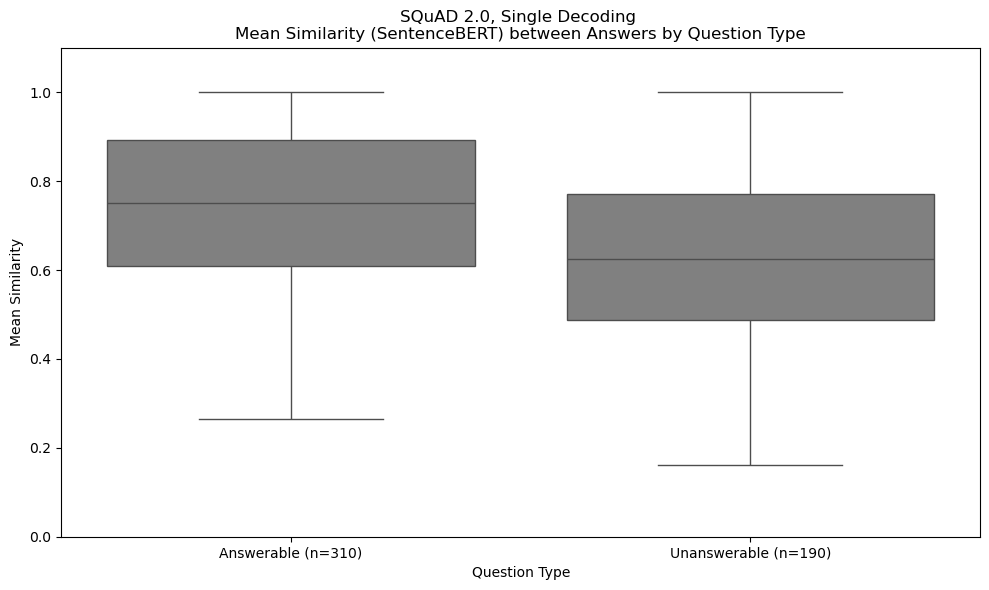

In [11]:
count_impossible = similarity_df_squad_single_sentencebert['is_impossible'].value_counts()
print(f"\nUnanswerable Questions Count:\n{count_impossible}")

# Compare mean similarity (consistency) between unanswerable and answerable questions
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="is_impossible",
    y="mean_similarity",
    data=similarity_df_squad_single_sentencebert,
    showfliers=True,
    color="grey"
)
plt.title("SQuAD 2.0, Single Decoding \nMean Similarity (SentenceBERT) between Answers by Question Type")
plt.ylabel("Mean Similarity")
plt.xlabel("Question Type")
plt.xticks([0, 1], ["Answerable (n=310)", "Unanswerable (n=190)"])
plt.ylim(0, 1.1)
plt.tight_layout()
plt.savefig("figures/metrics/sampling_consistency/meansim_boxplot_squad_single_sentencebert.png")
plt.show()

## Mutli Decoding: SentenceBERT

In [13]:
# Compute SentenceBERT similarity for SQuAD dataset
similarity_df_squad_multi_sentencebert = compute_sentenceBERT_similarity(
    df=df_parsed_squad_multi,
    question_id_col="question_id",
    answer_col="parsed_answer",
    is_impossible_col="is_impossible"
)
similarity_df_squad_multi_sentencebert["dataset"] = "SQuAD"

print(similarity_df_squad_multi_sentencebert.shape)

num_unanswerable = similarity_df_squad_multi_sentencebert[similarity_df_squad_multi_sentencebert["is_impossible"] == True].shape[0]
print(f"Number of unanswerable questions in similarity_df_squad_multi_sentencebert: {num_unanswerable}")

similarity_df_squad_multi_sentencebert.head(15)

(500, 7)
Number of unanswerable questions in similarity_df_squad_multi_sentencebert: 190


,question_id,is_impossible,num_answers,mean_similarity,std_similarity,n_pairs,dataset
0,0,False,5,0.395632,0.395833,10,SQuAD
1,1,False,5,0.847754,0.186462,10,SQuAD
2,2,False,5,0.432889,0.228275,10,SQuAD
3,3,False,5,1.000000,0.000000,10,SQuAD
4,4,False,5,0.851100,0.182365,10,SQuAD
5,5,False,5,1.000000,0.000000,10,SQuAD
6,6,False,5,0.832146,0.091400,10,SQuAD
7,7,False,5,0.655715,0.301946,10,SQuAD
8,8,False,5,1.000000,0.000000,10,SQuAD
9,9,False,5,0.798681,0.246565,10,SQuAD



Unanswerable Questions Count:
is_impossible
False    310
True     190
Name: count, dtype: int64


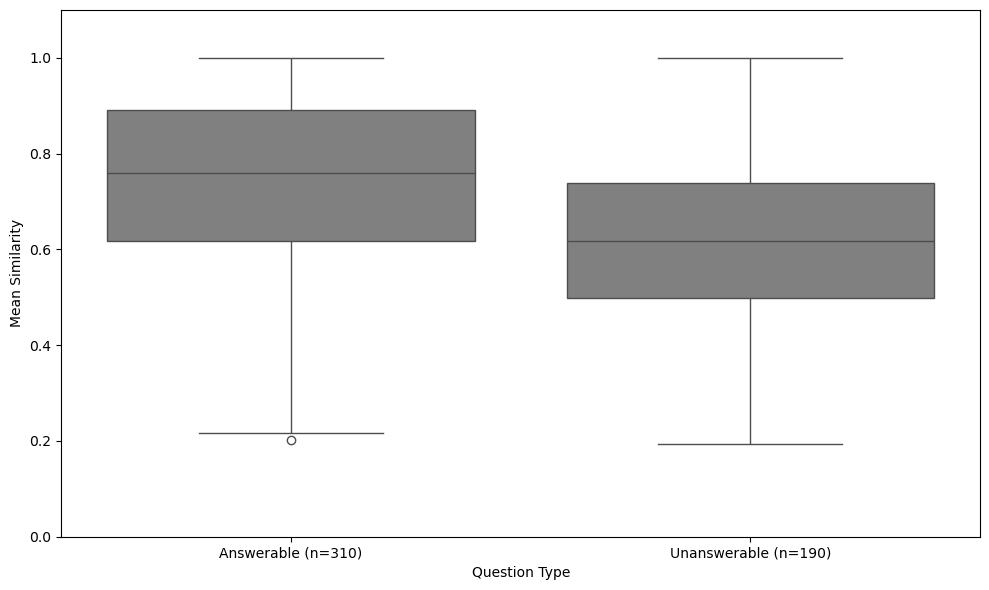

In [15]:
count_impossible = similarity_df_squad_multi_sentencebert['is_impossible'].value_counts()
print(f"\nUnanswerable Questions Count:\n{count_impossible}")

# Compare mean similarity (consistency) between unanswerable and answerable questions
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="is_impossible",
    y="mean_similarity",
    data=similarity_df_squad_multi_sentencebert,
    showfliers=True,
    color="grey"
)
#plt.title("SQuAD 2.0, Multi Decoding \nMean Similarity (SentenceBERT) between Answers by Question Type")
plt.ylabel("Mean Similarity")
plt.xlabel("Question Type")
plt.xticks([0, 1], ["Answerable (n=310)", "Unanswerable (n=190)"])
plt.ylim(0, 1.1)
plt.tight_layout()
plt.savefig("figures/metrics/sampling_consistency/meansim_boxplot_squad_multi_sentencebert.png")
plt.show()

## Single Decoding - RoBERTa

- Natural NLI setup:
    - Premise: ground truth (or question + ground truth)
    - Hypothesis: model's generated answers
- Output: P(entailment) = How strongly does this answer logically follow from the ground truth?

In [16]:
similarity_df_squad_single_roberta = compute_roberta_mnli_similarity(
    df=df_parsed_squad_single,
    question_id_col="question_id",
    answer_col="parsed_answer",
    is_impossible_col="is_impossible"
)
similarity_df_squad_single_roberta["dataset"] = "SQuAD"
similarity_df_squad_single_roberta.head(15)

,is_impossible,question_id,num_answers,n_pairs,mean_similarity,std_similarity,uncertainty,dataset
0,False,0,5,10,0.960388,5.960464e-08,0.039612,SQuAD
1,False,1,5,10,0.571103,3.226230e-01,0.428897,SQuAD
2,False,2,5,10,0.441188,1.881545e-01,0.558812,SQuAD
3,False,3,5,10,0.730244,1.917994e-01,0.269756,SQuAD
4,False,4,5,10,0.553073,3.238958e-01,0.446927,SQuAD
5,False,5,5,10,0.700881,3.250829e-01,0.299119,SQuAD
6,False,6,5,10,0.521843,1.798920e-01,0.478157,SQuAD
7,False,7,5,10,0.559710,1.646457e-01,0.440290,SQuAD
8,False,8,5,10,0.953612,5.960464e-08,0.046388,SQuAD
9,False,9,5,10,0.829489,1.662498e-01,0.170511,SQuAD



Unanswerable Questions Count (RoBERTa):
{False: 310, True: 190}


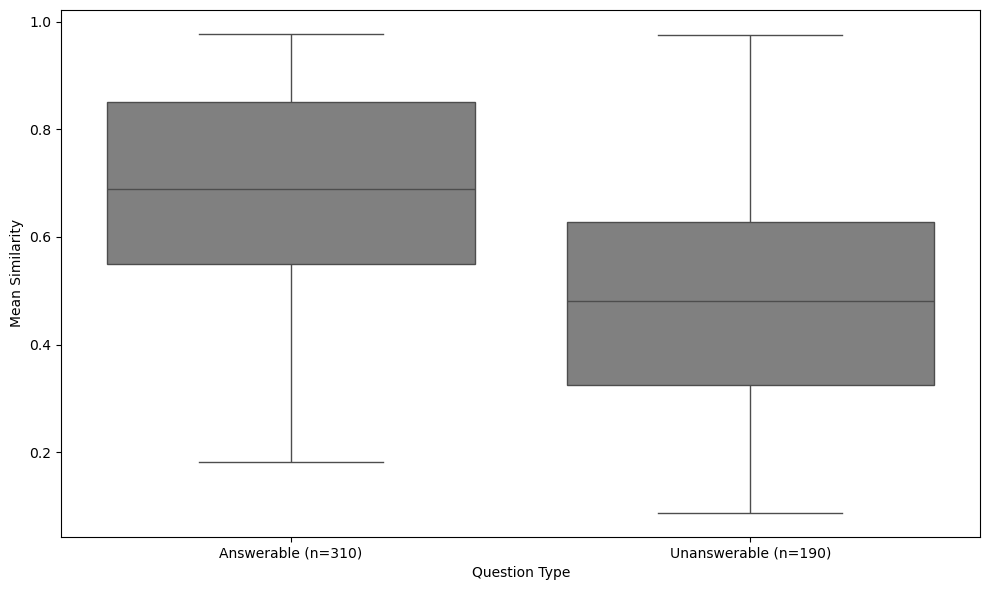

In [17]:
# Boxplot by category is_impossible
counts_impossible = similarity_df_squad_single_roberta['is_impossible'].value_counts().to_dict()
print(f"\nUnanswerable Questions Count (RoBERTa):\n{counts_impossible}")

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="is_impossible",
    y="mean_similarity",
    data=similarity_df_squad_single_roberta,
    showfliers=True,
    color="grey"
)
#plt.title("SQuAD 2.0, Single Decoding\nMean Similarity (RoBERTa-MNLI) between Answers by Question Type")
plt.ylabel("Mean Similarity")
plt.xlabel("Question Type")
plt.xticks([0, 1], ["Answerable (n=310)", "Unanswerable (n=190)"])
plt.tight_layout()
plt.savefig("figures/metrics/sampling_consistency/meansim_boxplot_squad_single_roberta.png")
plt.show()

## Multi Decoding - RoBERTa

In [18]:
similarity_df_squad_multi_roberta = compute_roberta_mnli_similarity(
    df=df_parsed_squad_multi,
    question_id_col="question_id",
    answer_col="parsed_answer",
    is_impossible_col="is_impossible"
)
similarity_df_squad_multi_roberta["dataset"] = "SQuAD"
similarity_df_squad_multi_roberta.head(15)

,is_impossible,question_id,num_answers,n_pairs,mean_similarity,std_similarity,uncertainty,dataset
0,False,0,5,10,0.311271,4.252492e-01,0.688729,SQuAD
1,False,1,5,10,0.871730,1.199550e-01,0.128270,SQuAD
2,False,2,5,10,0.227124,1.819073e-01,0.772876,SQuAD
3,False,3,5,10,0.960735,5.960464e-08,0.039265,SQuAD
4,False,4,5,10,0.766000,2.499817e-01,0.234000,SQuAD
5,False,5,5,10,0.966310,0.000000e+00,0.033690,SQuAD
6,False,6,5,10,0.821309,1.298351e-01,0.178691,SQuAD
7,False,7,5,10,0.582785,2.633314e-01,0.417215,SQuAD
8,False,8,5,10,0.953612,5.960464e-08,0.046388,SQuAD
9,False,9,5,10,0.654599,3.804460e-01,0.345401,SQuAD



Unanswerable Questions Count (RoBERTa):
{False: 310, True: 190}


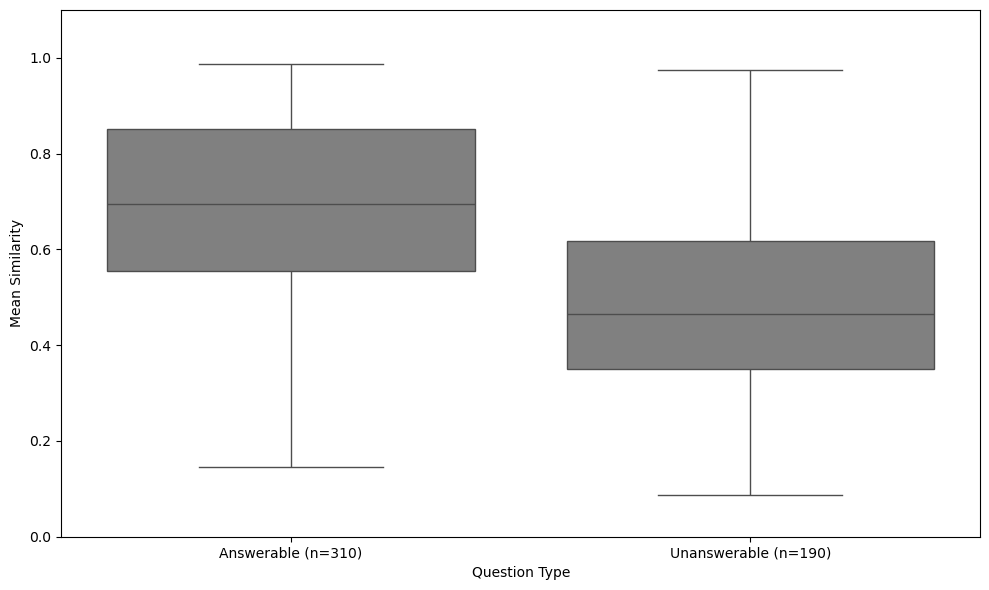

In [19]:
# Boxplot by category is_impossible
counts_impossible = similarity_df_squad_multi_roberta['is_impossible'].value_counts().to_dict()
print(f"\nUnanswerable Questions Count (RoBERTa):\n{counts_impossible}")

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="is_impossible",
    y="mean_similarity",
    data=similarity_df_squad_multi_roberta,
    showfliers=True,
    color="grey"
)
#plt.title("SQuAD 2.0, Multi Decoding\nMean Similarity (RoBERTa-MNLI) between Answers by Question Type")
plt.ylabel("Mean Similarity")
plt.xlabel("Question Type")
plt.xticks([0, 1], ["Answerable (n=310)", "Unanswerable (n=190)"])
plt.ylim(0, 1.1)
plt.tight_layout()
plt.savefig("figures/metrics/sampling_consistency/meansim_boxplot_squad_multi_roberta.png")
plt.show()

# Analysis of TriviaQA Dataset
## Single Decoding - SentenceBERT

In [20]:
# Compute SentenceBERT similarity for TriviaQA dataset
similarity_df_trivia_single_sentencebert = compute_sentenceBERT_similarity(
    df=df_parsed_trivia_single,
    question_id_col="question_id",
    answer_col="parsed_answer"
)
similarity_df_trivia_single_sentencebert["dataset"] = "TriviaQA"

print(similarity_df_trivia_single_sentencebert.shape)
print(similarity_df_trivia_single_sentencebert.head(15))

(500, 6)
    question_id  num_answers  mean_similarity  std_similarity  n_pairs  \
0             0            5         0.272454        0.099359       10   
1             1            5         0.649710        0.429016       10   
2             2            5         0.315903        0.216777       10   
3             3            5         0.608800        0.339919       10   
4             4            5         0.152863        0.130774       10   
5             5            5         0.295819        0.334336       10   
6             6            5         0.876866        0.100539       10   
7             7            5         0.672047        0.401659       10   
8             8            5         0.406616        0.186154       10   
9             9            5         0.383099        0.313105       10   
10           10            5         0.465198        0.344009       10   
11           11            5         0.497506        0.332089       10   
12           12            5 

## Multi Decoding - SentenceBERT

In [21]:
# Compute SentenceBERT similarity for TriviaQA dataset
similarity_df_trivia_multi_sentencebert = compute_sentenceBERT_similarity(
    df=df_parsed_trivia_multi,
    question_id_col="question_id",
    answer_col="parsed_answer"
)
similarity_df_trivia_multi_sentencebert["dataset"] = "TriviaQA"

print(similarity_df_trivia_multi_sentencebert.shape)
print(similarity_df_trivia_multi_sentencebert.head(15))

(500, 6)
    question_id  num_answers  mean_similarity  std_similarity  n_pairs  \
0             0            5         0.378343        0.216622       10   
1             1            5         1.000000        0.000000       10   
2             2            5         0.378541        0.235722       10   
3             3            5         0.685064        0.385716       10   
4             4            5         0.259744        0.244600       10   
5             5            5         0.598267        0.277639       10   
6             6            5         0.462622        0.345692       10   
7             7            5         0.384409        0.420391       10   
8             8            5         0.255900        0.152849       10   
9             9            5         0.145395        0.095475       10   
10           10            5         0.927030        0.089369       10   
11           11            5         0.580585        0.148810       10   
12           12            5 

## Single Decoding - RoBERTa

In [22]:
similarity_df_trivia_single_roberta = compute_roberta_mnli_similarity(
    df=df_parsed_trivia_single,
    question_id_col="question_id",
    answer_col="parsed_answer",
    is_impossible_col=None
)
similarity_df_trivia_single_roberta["dataset"] = "TriviaQA"
similarity_df_trivia_single_roberta.head(15)

,question_id,num_answers,n_pairs,mean_similarity,std_similarity,uncertainty,dataset
0,0,5,10,0.447108,0.313136,0.552892,TriviaQA
1,1,5,10,0.581254,0.459630,0.418746,TriviaQA
2,2,5,10,0.161338,0.171966,0.838662,TriviaQA
3,3,5,10,0.526361,0.403706,0.473639,TriviaQA
4,4,5,10,0.068444,0.130355,0.931556,TriviaQA
5,5,5,10,0.262135,0.319330,0.737865,TriviaQA
6,6,5,10,0.392222,0.467585,0.607778,TriviaQA
7,7,5,10,0.594430,0.456241,0.405570,TriviaQA
8,8,5,10,0.412369,0.229985,0.587631,TriviaQA
9,9,5,10,0.240995,0.327009,0.759005,TriviaQA


## Multi Decoding - RoBERTa

In [23]:
similarity_df_trivia_multi_roberta = compute_roberta_mnli_similarity(
    df=df_parsed_trivia_multi,
    question_id_col="question_id",
    answer_col="parsed_answer",
    is_impossible_col=None
)
similarity_df_trivia_multi_roberta["dataset"] = "TriviaQA"
similarity_df_trivia_multi_roberta.head(15)

,question_id,num_answers,n_pairs,mean_similarity,std_similarity,uncertainty,dataset
0,0,5,10,0.465746,0.216139,0.534254,TriviaQA
1,1,5,10,0.956540,0.000000,0.043460,TriviaQA
2,2,5,10,0.120189,0.283095,0.879811,TriviaQA
3,3,5,10,0.731545,0.292506,0.268455,TriviaQA
4,4,5,10,0.239668,0.165334,0.760332,TriviaQA
5,5,5,10,0.424159,0.392252,0.575841,TriviaQA
6,6,5,10,0.236313,0.283047,0.763687,TriviaQA
7,7,5,10,0.317648,0.426029,0.682352,TriviaQA
8,8,5,10,0.356657,0.214032,0.643343,TriviaQA
9,9,5,10,0.034574,0.028403,0.965426,TriviaQA


# Compute evaluation metrics (AUROC, PR-AUC)
**ECE**
- ECE is useful, if we have probabilities or confidences, which is not the case here
- SentenceBERT and RoBERTa are similarity score -> ECE not really meaningful

**AUROC**
- only needs a contionuis score (here: similarity to ground truth) -> predict correctness

## Helper functions to compute evaluation metrics

In [24]:
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve

def evaluate_models(df, y_col, score_cols):
    y = df[y_col].astype(int).to_numpy()
    rows = []
    curves = {}
    for col in score_cols:
        s = df[col].to_numpy()

        # AUROC & PR-AUC
        auroc = roc_auc_score(y, s)
        pr_auc = average_precision_score(y, s)

        # nützliche Kurven (falls du später plotten möchtest)
        pr_prec, pr_rec, pr_thresh = precision_recall_curve(y, s)
        fpr, tpr, roc_thresh = roc_curve(y, s)

        curves[col] = {
            "precision": pr_prec, "recall": pr_rec, "pr_thresholds": pr_thresh,
            "fpr": fpr, "tpr": tpr, "roc_thresholds": roc_thresh
        }

        rows.append({"model_score": col, "AUROC": auroc, "PR-AUC(AP)": pr_auc})

    return pd.DataFrame(rows).sort_values("AUROC", ascending=False), curves

## SQuAD

In [25]:
# Remove column is_correct to avoid duplication during merge
similarity_df_squad_single_sentencebert = similarity_df_squad_single_sentencebert.drop(columns=["is_correct"], errors='ignore')

similarity_df_squad_single_sentencebert = similarity_df_squad_single_sentencebert.merge(
    eval_df_squad_single[['question_id', 'is_correct']],
    on='question_id',
    how='left'
)

similarity_df_squad_multi_sentencebert = similarity_df_squad_multi_sentencebert.drop(columns=["is_correct"], errors='ignore')
similarity_df_squad_multi_sentencebert= similarity_df_squad_multi_sentencebert.merge(
    eval_df_squad_multi[['question_id', 'is_correct']],
    on='question_id',
    how='left'
)

similarity_df_squad_single_roberta = similarity_df_squad_single_roberta.drop(columns=["is_correct"], errors='ignore')
similarity_df_squad_single_roberta = similarity_df_squad_single_roberta.merge(
    eval_df_squad_single[['question_id', 'is_correct']],
    on='question_id',
    how='left'
)

similarity_df_squad_multi_roberta = similarity_df_squad_multi_roberta.drop(columns=["is_correct"], errors='ignore')
similarity_df_squad_multi_roberta = similarity_df_squad_multi_roberta.merge(
    eval_df_squad_multi[['question_id', 'is_correct']],
    on='question_id',
    how='left'
)

In [26]:
# Compute AUROC for Squad dataset
metrics_table_squad_single_sentencebert, curves_squad_single_sentencebert = evaluate_models(
    df=similarity_df_squad_single_sentencebert,
    y_col="is_correct",
    score_cols=["mean_similarity", "std_similarity"]
)

metrics_table_squad_single_sentencebert_possible, curves_squad_single_sentencebert_possible = evaluate_models(
    df=similarity_df_squad_single_sentencebert[similarity_df_squad_single_sentencebert["is_impossible"] == False],
    y_col="is_correct",
    score_cols=["mean_similarity", "std_similarity"]
)

metrics_table_squad_multi_sentencebert, curves_squad_multi_sentencebert = evaluate_models(
    df=similarity_df_squad_multi_sentencebert,
    y_col="is_correct",
    score_cols=["mean_similarity", "std_similarity"]
)

metrics_table_squad_multi_sentencebert_possible, curves_squad_multi_sentencebert_possible = evaluate_models(
    df=similarity_df_squad_multi_sentencebert[similarity_df_squad_multi_sentencebert["is_impossible"] == False],
    y_col="is_correct",
    score_cols=["mean_similarity", "std_similarity"]
)

metrics_table_squad_single_roberta, curves_squad_single_roberta = evaluate_models(
    df=similarity_df_squad_single_roberta,
    y_col="is_correct",
    score_cols=["mean_similarity", "std_similarity", "uncertainty"]
)

metrics_table_squad_single_roberta_possible, curves_squad_single_roberta_possible = evaluate_models(
    df=similarity_df_squad_single_roberta[similarity_df_squad_single_roberta["is_impossible"] == False],
    y_col="is_correct",
    score_cols=["mean_similarity", "std_similarity", "uncertainty"]
)

metrics_table_squad_multi_roberta, curves_squad_multi_roberta = evaluate_models(
    df=similarity_df_squad_multi_roberta,
    y_col="is_correct",
    score_cols=["mean_similarity", "std_similarity", "uncertainty"]
)

metrics_table_squad_multi_roberta_possible, curves_squad_multi_roberta_possible = evaluate_models(
    df=similarity_df_squad_multi_roberta[similarity_df_squad_multi_roberta["is_impossible"] == False],
    y_col="is_correct",
    score_cols=["mean_similarity", "std_similarity", "uncertainty"]
)   

# Combine all metrics tables into one
all_metrics_tables_squad = {
    "SQuAD Single Decoding (SentenceBERT)": metrics_table_squad_single_sentencebert,
    "SQuAD Single Decoding (SentenceBERT, only answerable)": metrics_table_squad_single_sentencebert_possible,
    "SQuAD Multi Decoding (SentenceBERT)": metrics_table_squad_multi_sentencebert,
    "SQuAD Multi Decoding (SentenceBERT, only answerable)": metrics_table_squad_multi_sentencebert_possible,
    "SQuAD Single Decoding (RoBERTa-MNLI)": metrics_table_squad_single_roberta,
    "SQuAD Single Decoding (RoBERTa-MNLI, only answerable)": metrics_table_squad_single_roberta_possible,
    "SQuAD Multi Decoding (RoBERTa-MNLI)": metrics_table_squad_multi_roberta,
    "SQuAD Multi Decoding (RoBERTa-MNLI, only answerable)": metrics_table_squad_multi_roberta_possible
}   
for name, table in all_metrics_tables_squad.items():
    print(f"\n{name}:\n{table}")

print(all_metrics_tables_squad)

# Save all metrics tables to CSV files
for name, table in all_metrics_tables_squad.items():
    filename = name.lower().replace(" ", "_").replace("(", "").replace(")", "").replace("-", "_") + ".csv"
    table.to_csv(f"tables/metrics/sample_consistency/metrics_{filename}", index=False)


SQuAD Single Decoding (SentenceBERT):
       model_score     AUROC  PR-AUC(AP)
0  mean_similarity  0.679121    0.692159
1   std_similarity  0.438111    0.533430

SQuAD Single Decoding (SentenceBERT, only answerable):
       model_score     AUROC  PR-AUC(AP)
0  mean_similarity  0.648454    0.915915
1   std_similarity  0.427150    0.850559

SQuAD Multi Decoding (SentenceBERT):
       model_score     AUROC  PR-AUC(AP)
0  mean_similarity  0.701406    0.710654
1   std_similarity  0.431626    0.507487

SQuAD Multi Decoding (SentenceBERT, only answerable):
       model_score     AUROC  PR-AUC(AP)
0  mean_similarity  0.684705    0.916189
1   std_similarity  0.380888    0.800740

SQuAD Single Decoding (RoBERTa-MNLI):
       model_score     AUROC  PR-AUC(AP)
0  mean_similarity  0.739385    0.726929
1   std_similarity  0.416190    0.487364
2      uncertainty  0.260615    0.394857

SQuAD Single Decoding (RoBERTa-MNLI, only answerable):
       model_score     AUROC  PR-AUC(AP)
0  mean_similarity  

## TriviaQA

In [27]:
similarity_df_trivia_single_sentencebert = similarity_df_trivia_single_sentencebert.merge(
    eval_df_trivia_single[['question_id', 'is_correct']],
    on='question_id',
    how='left'
)

similarity_df_trivia_multi_sentencebert = similarity_df_trivia_multi_sentencebert.merge(
    eval_df_trivia_multi[['question_id', 'is_correct']],
    on='question_id',
    how='left'
)

similarity_df_trivia_single_roberta = similarity_df_trivia_single_roberta.merge(
    eval_df_trivia_single[['question_id', 'is_correct']],
    on='question_id',
    how='left'
)

similarity_df_trivia_multi_roberta = similarity_df_trivia_multi_roberta.merge(
    eval_df_trivia_multi[['question_id', 'is_correct']],
    on='question_id',
    how='left'
)


In [28]:
# Compute AUROC for TriviaQA dataset
metrics_table_trivia_single_sentencebert, curves_trivia_single_sentencebert = evaluate_models(
    df=similarity_df_trivia_single_sentencebert,
    y_col="is_correct",
    score_cols=["mean_similarity", "std_similarity"]
)

metrics_table_trivia_multi_sentencebert, curves_trivia_multi_sentencebert = evaluate_models(
    df=similarity_df_trivia_single_roberta,
    y_col="is_correct",
    score_cols=["mean_similarity", "std_similarity"]
)

metrics_table_trivia_single_roberta, curves_trivia_single_roberta = evaluate_models(
    df=similarity_df_trivia_single_roberta,
    y_col="is_correct",
    score_cols=["mean_similarity", "std_similarity", "uncertainty"]
)

metrics_table_trivia_multi_roberta, curves_trivia_multi_roberta = evaluate_models(
    df=similarity_df_trivia_multi_roberta,
    y_col="is_correct",
    score_cols=["mean_similarity", "std_similarity", "uncertainty"]
)

# Combine all metrics tables into one
all_metrics_tables_trivia = {
    "TriviaQA Single Decoding (SentenceBERT)": metrics_table_trivia_single_sentencebert,
    "TriviaQA Multi Decoding (SentenceBERT)": metrics_table_trivia_multi_sentencebert,
    "TriviaQA Single Decoding (RoBERTa-MNLI)": metrics_table_trivia_single_roberta,
    "TriviaQA Multi Decoding (RoBERTa-MNLI)": metrics_table_trivia_multi_roberta
}
for name, table in all_metrics_tables_trivia.items():
    print(f"\n{name}:\n{table}")

print(all_metrics_tables_trivia)

# Save all metrics tables to CSV files
for name, table in all_metrics_tables_trivia.items():
    filename = name.lower().replace(" ", "_").replace("(", "").replace(")", "").replace("-", "_") + ".csv"
    table.to_csv(f"tables/metrics/sample_consistency/metrics_{filename}", index=False)


TriviaQA Single Decoding (SentenceBERT):
       model_score     AUROC  PR-AUC(AP)
0  mean_similarity  0.760259    0.740517
1   std_similarity  0.669035    0.723291

TriviaQA Multi Decoding (SentenceBERT):
       model_score     AUROC  PR-AUC(AP)
0  mean_similarity  0.793243    0.748925
1   std_similarity  0.674933    0.712755

TriviaQA Single Decoding (RoBERTa-MNLI):
       model_score     AUROC  PR-AUC(AP)
0  mean_similarity  0.793243    0.748925
1   std_similarity  0.674933    0.712755
2      uncertainty  0.206757    0.353090

TriviaQA Multi Decoding (RoBERTa-MNLI):
       model_score     AUROC  PR-AUC(AP)
0  mean_similarity  0.793037    0.804909
1   std_similarity  0.578231    0.596436
2      uncertainty  0.206963    0.355568
{'TriviaQA Single Decoding (SentenceBERT)':        model_score     AUROC  PR-AUC(AP)
0  mean_similarity  0.760259    0.740517
1   std_similarity  0.669035    0.723291, 'TriviaQA Multi Decoding (SentenceBERT)':        model_score     AUROC  PR-AUC(AP)
0  mean_s

# Plots and Tables for Presentation & Report
## Evaluation Metrices Table

In [29]:
# Create accuracy summary table with squad only answerables
acc_table = pd.DataFrame([
    {"model": "llama3.2-3B", "dataset": "SQuAD 2.0", "decoding": "single", "accuracy": eval_df_squad_single.loc[mask_ans,'is_correct'].mean()},
    {"model": "llama3.2-3B", "dataset": "SQuAD 2.0", "decoding": "multi", "accuracy": eval_df_squad_multi.loc[mask_ans,'is_correct'].mean()},
    {"model": "llama3.2-3B", "dataset": "TriviaQA", "decoding": "single", "accuracy": acc_trivia_single},
    {"model": "llama3.2-3B", "dataset": "TriviaQA", "decoding": "multi", "accuracy": acc_trivia_multi}
])
print("\nAccuracy Table:")
print(acc_table)

# Save accuracy table to CSV
#acc_table.to_csv("tables/metrics/sample_consistency/accuracy_table.csv", index=False)


Accuracy Table:
         model    dataset decoding  accuracy
0  llama3.2-3B  SQuAD 2.0   single  0.864516
1  llama3.2-3B  SQuAD 2.0    multi  0.832258
2  llama3.2-3B   TriviaQA   single  0.508000
3  llama3.2-3B   TriviaQA    multi  0.510000


In [150]:
auroc_table = pd.DataFrame([
    {"model": "llama3.2-3B", "dataset": "SQuAD 2.0", "decoding": "single", "method": "SentenceBERT", "score_type": row['model_score'], "AUROC": row['AUROC'], "PR-AUC(AP)": row['PR-AUC(AP)']} 
    for _, row in metrics_table_squad_single_sentencebert_possible.iterrows()
] + [
    {"model": "llama3.2-3B", "dataset": "SQuAD 2.0", "decoding": "multi", "method": "SentenceBERT", "score_type": row['model_score'], "AUROC": row['AUROC'], "PR-AUC(AP)": row['PR-AUC(AP)']} 
    for _, row in metrics_table_squad_multi_sentencebert_possible.iterrows()
] + [
    {"model": "llama3.2-3B", "dataset": "SQuAD 2.0", "decoding": "single", "method": "RoBERTa-MNLI", "score_type": row['model_score'], "AUROC": row['AUROC'], "PR-AUC(AP)": row['PR-AUC(AP)']} 
    for _, row in metrics_table_squad_single_roberta.iterrows()
] + [
    {"model": "llama3.2-3B", "dataset": "SQuAD 2.0", "decoding": "multi", "method": "RoBERTa-MNLI", "score_type": row['model_score'], "AUROC": row['AUROC'], "PR-AUC(AP)": row['PR-AUC(AP)']} 
    for _, row in metrics_table_squad_multi_roberta.iterrows()
] + [
    {"model": "llama3.2-3B", "dataset": "TriviaQA", "decoding": "single", "method": "SentenceBERT", "score_type": row['model_score'], "AUROC": row['AUROC'], "PR-AUC(AP)": row['PR-AUC(AP)']} 
    for _, row in metrics_table_trivia_single_sentencebert.iterrows()
] + [
    {"model": "llama3.2-3B", "dataset": "TriviaQA", "decoding": "multi", "method": "SentenceBERT", "score_type": row['model_score'], "AUROC": row['AUROC'], "PR-AUC(AP)": row['PR-AUC(AP)']}
    for _, row in metrics_table_trivia_multi_sentencebert.iterrows()
] + [
    {"model": "llama3.2-3B", "dataset": "TriviaQA", "decoding": "single", "method": "RoBERTa-MNLI", "score_type": row['model_score'], "AUROC": row['AUROC'], "PR-AUC(AP)": row['PR-AUC(AP)']} 
    for _, row in metrics_table_trivia_single_roberta.iterrows()
] + [
    {"model": "llama3.2-3B", "dataset": "TriviaQA", "decoding": "multi", "method": "RoBERTa-MNLI", "score_type": row['model_score'], "AUROC": row['AUROC'], "PR-AUC(AP)": row['PR-AUC(AP)']} 
    for _, row in metrics_table_trivia_multi_roberta.iterrows()
])

print("\nAUROC Table:")
print(auroc_table)

# Save accuracy table to CSV
auroc_table.to_csv("tables/metrics/sample_consistency/auroc_table.csv", index=False)


AUROC Table:
          model    dataset decoding        method       score_type     AUROC  \
0   llama3.2-3B  SQuAD 2.0   single  SentenceBERT  mean_similarity  0.648454   
1   llama3.2-3B  SQuAD 2.0   single  SentenceBERT   std_similarity  0.427150   
2   llama3.2-3B  SQuAD 2.0    multi  SentenceBERT  mean_similarity  0.684705   
3   llama3.2-3B  SQuAD 2.0    multi  SentenceBERT   std_similarity  0.380888   
4   llama3.2-3B  SQuAD 2.0   single  RoBERTa-MNLI  mean_similarity  0.739385   
5   llama3.2-3B  SQuAD 2.0   single  RoBERTa-MNLI   std_similarity  0.416190   
6   llama3.2-3B  SQuAD 2.0   single  RoBERTa-MNLI      uncertainty  0.260615   
7   llama3.2-3B  SQuAD 2.0    multi  RoBERTa-MNLI  mean_similarity  0.757864   
8   llama3.2-3B  SQuAD 2.0    multi  RoBERTa-MNLI   std_similarity  0.378468   
9   llama3.2-3B  SQuAD 2.0    multi  RoBERTa-MNLI      uncertainty  0.242136   
10  llama3.2-3B   TriviaQA   single  SentenceBERT  mean_similarity  0.760259   
11  llama3.2-3B   TriviaQA

In [30]:
# Mean similarity for single and multi decoding (SentenceBERT)
print("\nMean Similarity Comparison (SentenceBERT):")
mean_sim_comparison_sentencebert = pd.DataFrame([
    {"model": "llama3.2-3B", "dataset": "SQuAD 2.0", "decoding": "single", "mean_similarity": similarity_df_squad_single_sentencebert["mean_similarity"].mean()},
    {"model": "llama3.2-3B", "dataset": "SQuAD 2.0", "decoding": "multi", "mean_similarity": similarity_df_squad_multi_sentencebert["mean_similarity"].mean()},
    {"model": "llama3.2-3B", "dataset": "TriviaQA", "decoding": "single", "mean_similarity": similarity_df_trivia_single_sentencebert["mean_similarity"].mean()},
    {"model": "llama3.2-3B", "dataset": "TriviaQA", "decoding": "multi", "mean_similarity": similarity_df_trivia_multi_sentencebert["mean_similarity"].mean()}
])
print(mean_sim_comparison_sentencebert)

# Mean similarity for single and multi decoding (RoBERTa-MNLI)
print("\nMean Similarity Comparison (RoBERTa-MNLI):")
mean_sim_comparison_roberta = pd.DataFrame([
    {"model": "llama3.2-3B", "dataset": "SQuAD 2.0", "decoding": "single", "mean_similarity": similarity_df_squad_single_roberta["mean_similarity"].mean()},
    {"model": "llama3.2-3B", "dataset": "SQuAD 2.0", "decoding": "multi", "mean_similarity": similarity_df_squad_multi_roberta["mean_similarity"].mean()},
    {"model": "llama3.2-3B", "dataset": "TriviaQA", "decoding": "single", "mean_similarity": similarity_df_trivia_single_roberta["mean_similarity"].mean()},
    {"model": "llama3.2-3B", "dataset": "TriviaQA", "decoding": "multi", "mean_similarity": similarity_df_trivia_multi_roberta["mean_similarity"].mean()}
])
print(mean_sim_comparison_roberta)


Mean Similarity Comparison (SentenceBERT):
         model    dataset decoding  mean_similarity
0  llama3.2-3B  SQuAD 2.0   single         0.694764
1  llama3.2-3B  SQuAD 2.0    multi         0.694004
2  llama3.2-3B   TriviaQA   single         0.493688
3  llama3.2-3B   TriviaQA    multi         0.498453

Mean Similarity Comparison (RoBERTa-MNLI):
         model    dataset decoding  mean_similarity
0  llama3.2-3B  SQuAD 2.0   single         0.616078
1  llama3.2-3B  SQuAD 2.0    multi         0.615061
2  llama3.2-3B   TriviaQA   single         0.374910
3  llama3.2-3B   TriviaQA    multi         0.381229


## Plots

(310, 8)


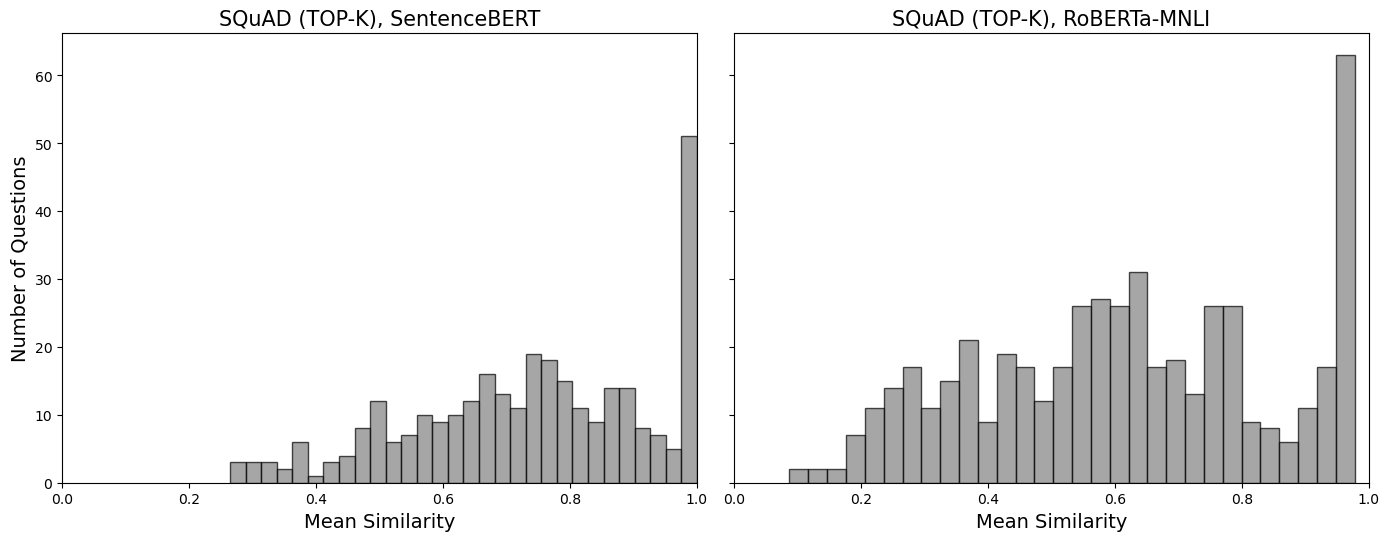

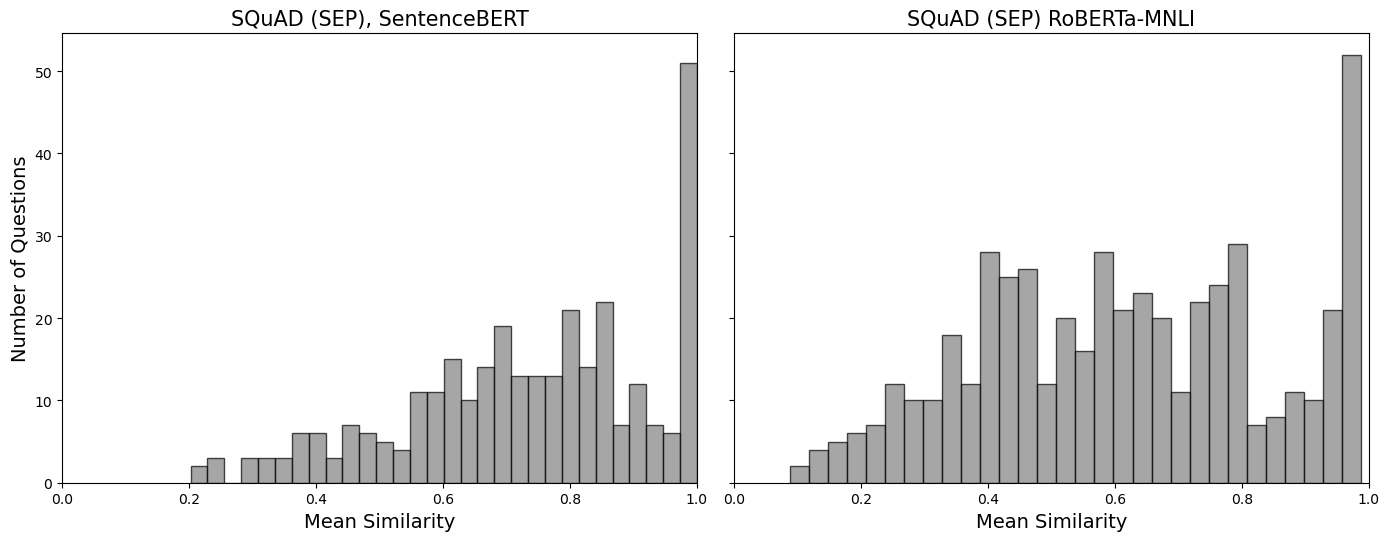

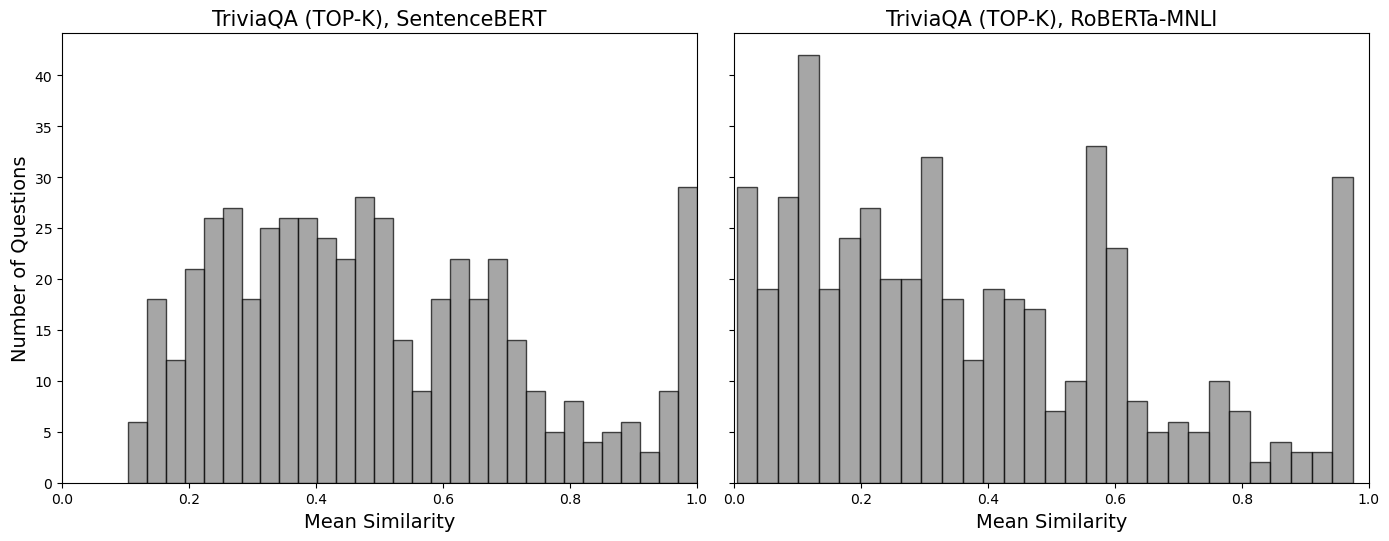

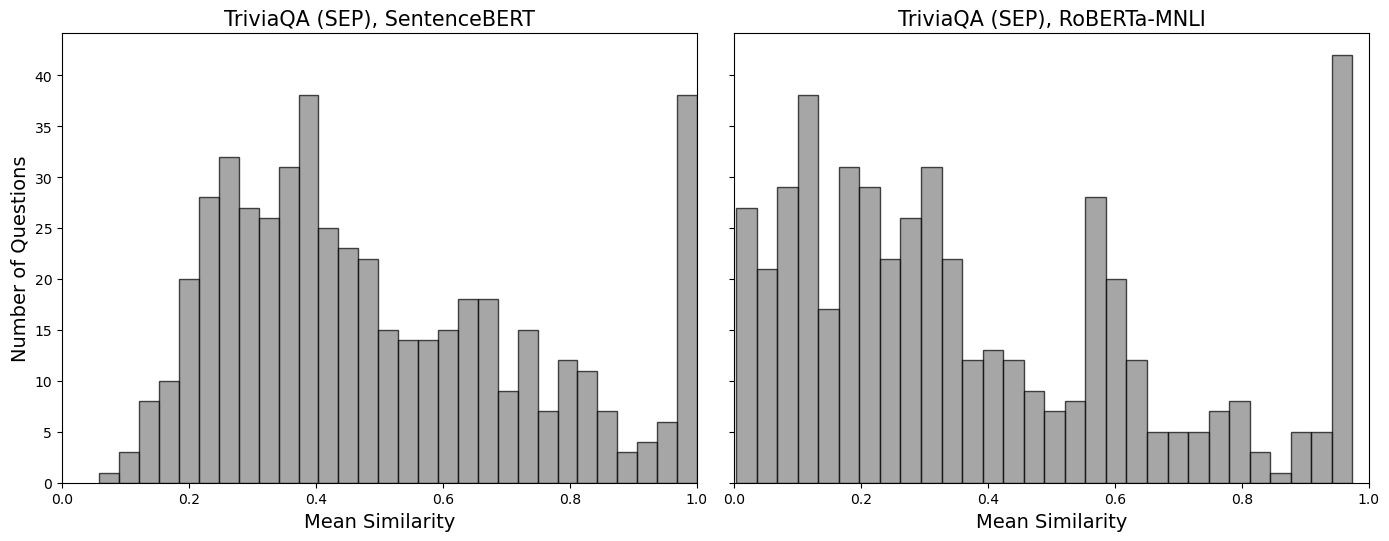

In [33]:
print(similarity_df_squad_single_sentencebert[similarity_df_squad_single_sentencebert["is_impossible"] == False].shape)
similarity_df_squad_single_sentencebert_possible = similarity_df_squad_single_sentencebert[similarity_df_squad_single_sentencebert["is_impossible"] == False]
similarity_df_squad_single_roberta_possible = similarity_df_squad_single_roberta[similarity_df_squad_single_roberta["is_impossible"] == False]
similarity_df_squad_multi_sentencebert_possible = similarity_df_squad_multi_sentencebert[similarity_df_squad_multi_sentencebert["is_impossible"] == False]
similarity_df_squad_multi_roberta_possible = similarity_df_squad_multi_roberta[similarity_df_squad_multi_roberta["is_impossible"] == False]


# Two Barplots side by side: Mean similarity distribution for Squad. One for SentenceBERT, one for RoBERTa-MNLI
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Barplot für SentenceBERT
axes[0].hist(
    similarity_df_squad_single_sentencebert_possible["mean_similarity"], 
    bins=30, color="grey", alpha=0.7, edgecolor='black'
)
axes[0].set_xlim(0, 1)
axes[0].set_title("SQuAD (TOP-K), SentenceBERT", fontsize=15)
axes[0].set_xlabel("Mean Similarity", fontsize=14)
axes[0].set_ylabel("Number of Questions", fontsize=14)


# RoBERTa-MNLI
axes[1].hist(
    similarity_df_squad_single_roberta["mean_similarity"], 
    bins=30, color="grey", alpha=0.7, edgecolor='black'
)
axes[1].set_title("SQuAD (TOP-K), RoBERTa-MNLI", fontsize=15)
axes[1].set_xlabel("Mean Similarity", fontsize=14)
axes[1].set_xlim(0, 1)

#plt.suptitle("Mean Similarity Distribution Comparison for SQuAD 2.0, Single Decoding\nTotal Questions: 310, Samples: 1548")
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.savefig("figures/metrics/sampling_consistency/meansim_histogram_squad_single_comparison.png")
plt.show()

# Mean similarity distribution for Squad, multi decoding
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
# Barplot für SentenceBERT
axes[0].hist(
    similarity_df_squad_multi_sentencebert_possible["mean_similarity"], 
    bins=30, color="grey", alpha=0.7, edgecolor='black'
)
axes[0].set_xlim(0, 1)
axes[0].set_title("SQuAD (SEP), SentenceBERT", fontsize=15)
axes[0].set_xlabel("Mean Similarity", fontsize=14)
axes[0].set_ylabel("Number of Questions", fontsize=14)

# RoBERTa-MNLI
axes[1].hist(
    similarity_df_squad_multi_roberta["mean_similarity"], 
    bins=30, color="grey", alpha=0.7, edgecolor='black'
)
axes[1].set_title("SQuAD (SEP) RoBERTa-MNLI", fontsize=15)
axes[1].set_xlabel("Mean Similarity", fontsize=14)
axes[1].set_xlim(0, 1)

#plt.suptitle("Mean Similarity Distribution Comparison for SQuAD 2.0, Multi Decoding\nTotal Questions: 310, Samples: 1550")
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.savefig("figures/metrics/sampling_consistency/meansim_histogram_squad_multi_comparison.png")
plt.show()

# Mean similarity distribution comparison for TriviaQA, single decoding
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
# Barplot für SentenceBERT
axes[0].hist(
    similarity_df_trivia_single_sentencebert["mean_similarity"], 
    bins=30, color="grey", alpha=0.7, edgecolor='black'
)
axes[0].set_xlim(0, 1)
axes[0].set_title("TriviaQA (TOP-K), SentenceBERT", fontsize=15)
axes[0].set_xlabel("Mean Similarity", fontsize=14)
axes[0].set_ylabel("Number of Questions", fontsize=14)

# RoBERTa-MNLI
axes[1].hist(
    similarity_df_trivia_single_roberta["mean_similarity"], 
    bins=30, color="grey", alpha=0.7, edgecolor='black'
)
axes[1].set_title("TriviaQA (TOP-K), RoBERTa-MNLI", fontsize=15)
axes[1].set_xlabel("Mean Similarity", fontsize=14)
axes[1].set_xlim(0, 1)

#plt.suptitle("Mean Similarity Distribution Comparison for TriviaQA, Single Decoding\nTotal Questions: 500, Samples: 2496")
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.savefig("figures/metrics/sampling_consistency/meansim_histogram_trivia_single_comparison.png")
plt.show()

# Mean similarity distribution comparison for TriviaQA, multi decoding
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
# Barplot für SentenceBERT
axes[0].hist(
    similarity_df_trivia_multi_sentencebert["mean_similarity"], 
    bins=30, color="grey", alpha=0.7, edgecolor='black'
)
axes[0].set_xlim(0, 1)
axes[0].set_title("TriviaQA (SEP), SentenceBERT", fontsize=15)
axes[0].set_xlabel("Mean Similarity", fontsize=14)
axes[0].set_ylabel("Number of Questions", fontsize=14)

# RoBERTa-MNLI
axes[1].hist(
    similarity_df_trivia_multi_roberta["mean_similarity"], 
    bins=30, color="grey", alpha=0.7, edgecolor='black'
)
axes[1].set_title("TriviaQA (SEP), RoBERTa-MNLI", fontsize=15)
axes[1].set_xlabel("Mean Similarity", fontsize=14)
axes[1].set_xlim(0, 1)

#plt.suptitle("Mean Similarity Distribution Comparison for TriviaQA, Multi Decoding\nTotal Questions: 500, Samples: 2499")
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.savefig("figures/metrics/sampling_consistency/meansim_histogram_trivia_multi_comparison.png")
plt.show()

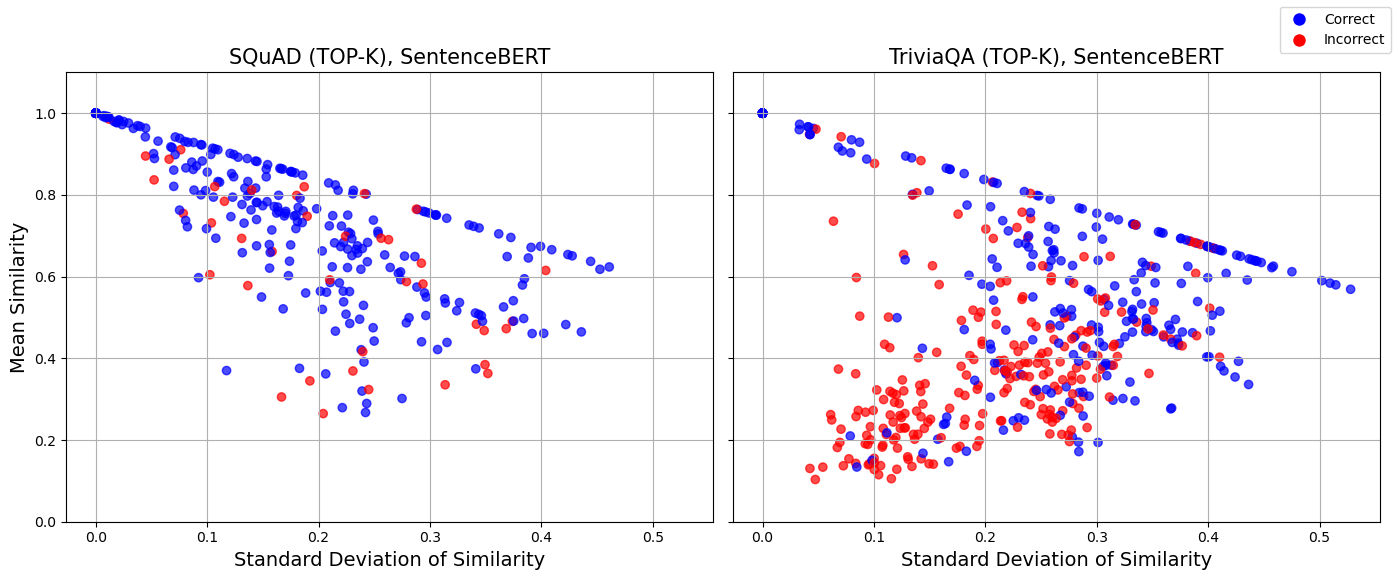

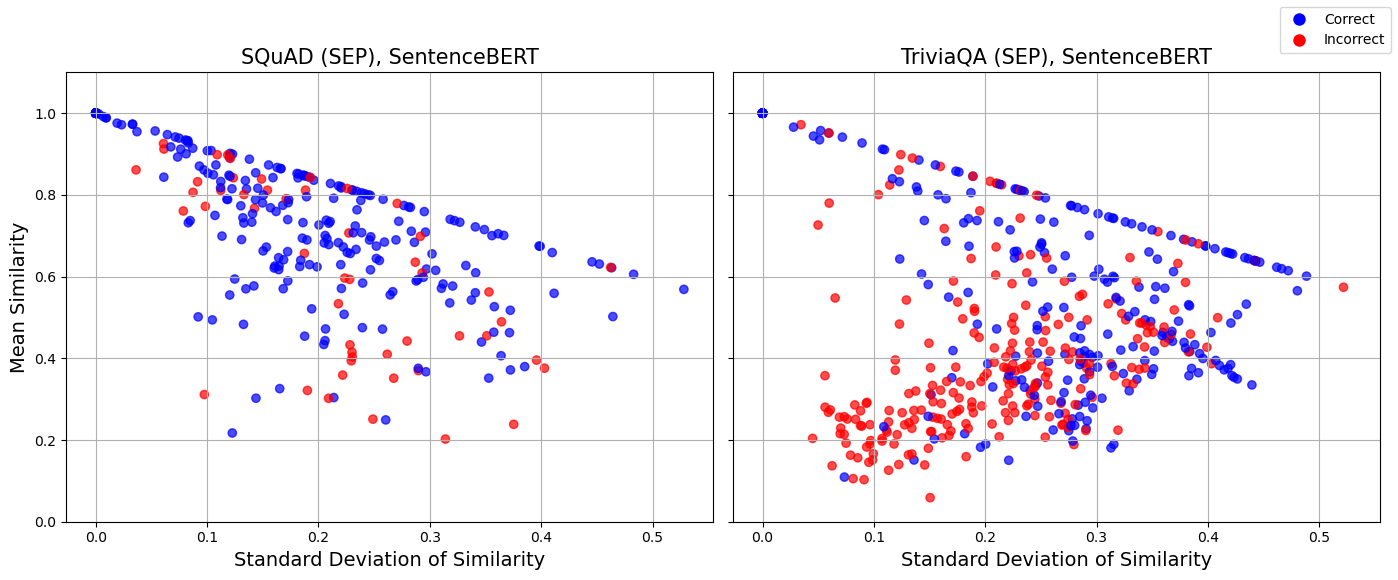

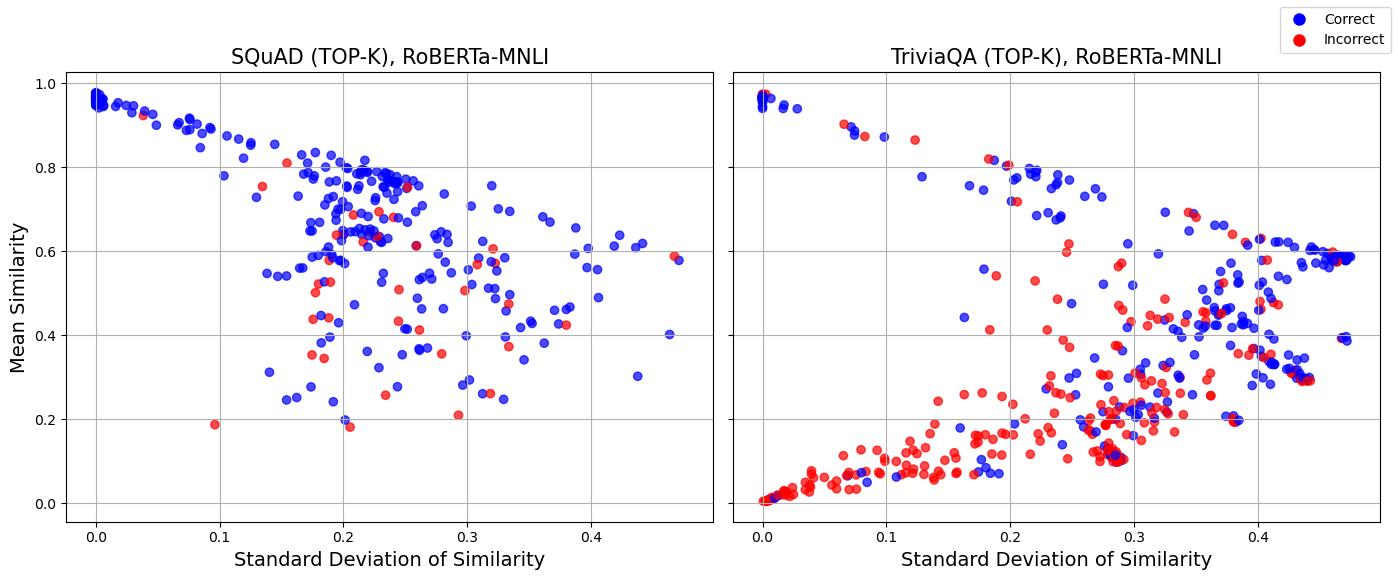

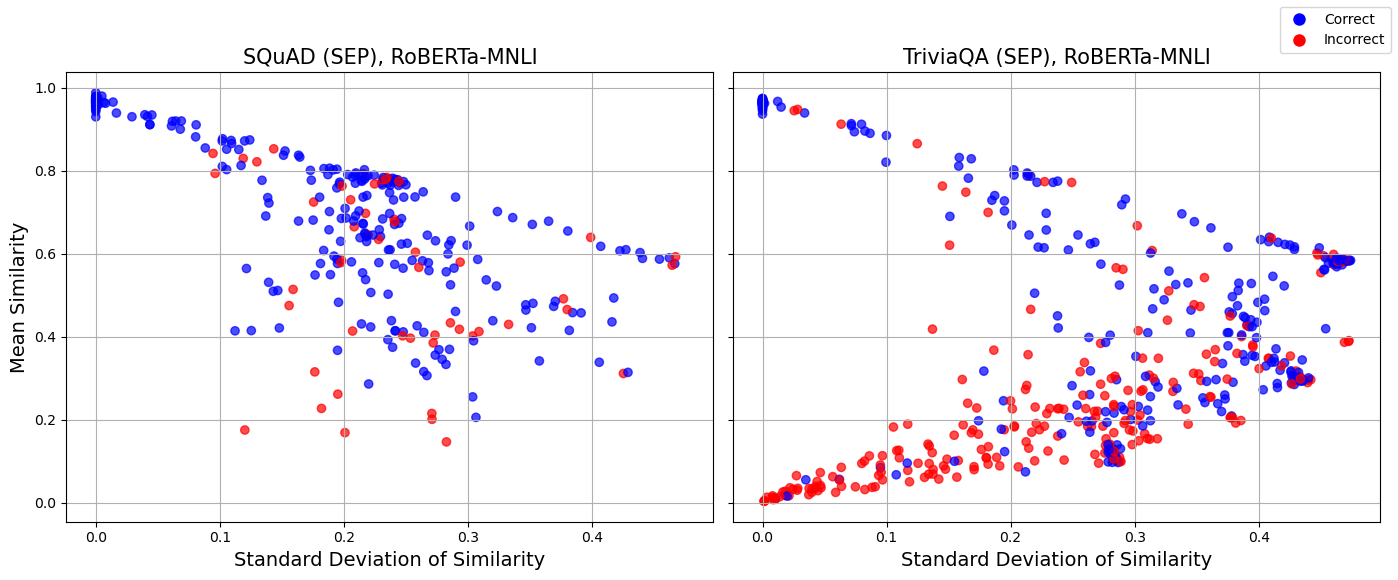

In [36]:
# Scatter plot of std vs mean similarity for SQuAD & Trivia single decoding (SentenceBERT) with color coding for is_correct side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True, sharex=True)
# SQuAD
scatter1 = axes[0].scatter(
    similarity_df_squad_single_sentencebert_possible['std_similarity'], 
    similarity_df_squad_single_sentencebert_possible['mean_similarity'],
    c=similarity_df_squad_single_sentencebert_possible['is_correct'].map({True: 'blue', False: 'red'}),
    alpha=0.7
    
)
axes[0].set_title("SQuAD (TOP-K), SentenceBERT", fontsize=15)
axes[0].set_xlabel("Standard Deviation of Similarity", fontsize=14)
axes[0].set_ylabel("Mean Similarity", fontsize=14)
axes[0].grid(True)
axes[0].set_ylim(0, 1.1)
# TriviaQA
scatter2 = axes[1].scatter(
    similarity_df_trivia_single_sentencebert['std_similarity'], 
    similarity_df_trivia_single_sentencebert['mean_similarity'],
    c=similarity_df_trivia_single_sentencebert['is_correct'].map({True: 'blue', False: 'red'}),
    alpha=0.7
)
axes[1].set_title("TriviaQA (TOP-K), SentenceBERT", fontsize=15)
axes[1].set_xlabel("Standard Deviation of Similarity", fontsize=14)
axes[1].grid(True)

# Gemeinsame Legende
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Correct', markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Incorrect', markerfacecolor='red', markersize=10)
]
fig.legend(handles=handles, loc='upper right')
#plt.suptitle("Standard Deviation and Mean Similarity")
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.savefig("figures/metrics/sampling_consistency/std_vs_meansim_squad_trivia_single_sentencebert.png")
plt.show()

# Scatter plot of std vs mean similarity for SQuAD & Trivia multi decoding (SentenceBERT) with color coding for is_correct side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True, sharex=True)
# SQuAD
scatter1 = axes[0].scatter(
    similarity_df_squad_multi_sentencebert_possible['std_similarity'],
    similarity_df_squad_multi_sentencebert_possible['mean_similarity'],
    c=similarity_df_squad_multi_sentencebert_possible['is_correct'].map({True: 'blue', False: 'red'}),
    alpha=0.7
)
axes[0].set_title("SQuAD (SEP), SentenceBERT", fontsize=15)
axes[0].set_xlabel("Standard Deviation of Similarity", fontsize=14)
axes[0].set_ylabel("Mean Similarity", fontsize=14)
axes[0].grid(True)
axes[0].set_ylim(0, 1.1)
# TriviaQA
scatter2 = axes[1].scatter(
    similarity_df_trivia_multi_sentencebert['std_similarity'],
    similarity_df_trivia_multi_sentencebert['mean_similarity'],
    c=similarity_df_trivia_multi_sentencebert['is_correct'].map({True: 'blue', False: 'red'}),
    alpha=0.7
)
axes[1].set_title("TriviaQA (SEP), SentenceBERT", fontsize=15)
axes[1].set_xlabel("Standard Deviation of Similarity", fontsize=14)
axes[1].grid(True)
# Gemeinsame Legende
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Correct', markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Incorrect', markerfacecolor='red', markersize=10)
]
fig.legend(handles=handles, loc='upper right')
#plt.suptitle("Standard Deviation and Mean Similarity")
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.savefig("figures/metrics/sampling_consistency/std_vs_meansim_squad_trivia_multi_sentencebert.png")
plt.show()

# Scatter plot of std vs mean similarity for SQuAD & Trivia single decoding (Roberta) with color coding for is_correct side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True, sharex=True)
# SQuAD
scatter1 = axes[0].scatter(
    similarity_df_squad_single_roberta_possible['std_similarity'],
    similarity_df_squad_single_roberta_possible['mean_similarity'],
    c=similarity_df_squad_single_roberta_possible['is_correct'].map({True: 'blue', False: 'red'}),
    alpha=0.7
)
axes[0].set_title("SQuAD (TOP-K), RoBERTa-MNLI", fontsize=15)
axes[0].set_xlabel("Standard Deviation of Similarity", fontsize=14)
axes[0].set_ylabel("Mean Similarity", fontsize=14)
axes[0].grid(True)
# TriviaQA
scatter2 = axes[1].scatter(
    similarity_df_trivia_single_roberta['std_similarity'],
    similarity_df_trivia_single_roberta['mean_similarity'],
    c=similarity_df_trivia_single_roberta['is_correct'].map({True: 'blue', False: 'red'}),
    alpha=0.7
)
axes[1].set_title("TriviaQA (TOP-K), RoBERTa-MNLI", fontsize=15)
axes[1].set_xlabel("Standard Deviation of Similarity", fontsize=14)
axes[1].grid(True) 

# Gemeinsame Legende
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Correct', markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Incorrect', markerfacecolor='red', markersize=10)
]   
fig.legend(handles=handles, loc='upper right')
#plt.suptitle("Standard Deviation and Mean Similarity")
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.savefig("figures/metrics/sampling_consistency/std_vs_meansim_squad_trivia_single_roberta.png")
plt.show()

# Scatter plot of std vs mean similarity for SQuAD & Trivia multi decoding (Roberta) with color coding for is_correct side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True, sharex=True)
# SQuAD
scatter1 = axes[0].scatter(
    similarity_df_squad_multi_roberta_possible['std_similarity'],
    similarity_df_squad_multi_roberta_possible['mean_similarity'],
    c=similarity_df_squad_multi_roberta_possible['is_correct'].map({True: 'blue', False: 'red'}),
    alpha=0.7
)
axes[0].set_title("SQuAD (SEP), RoBERTa-MNLI", fontsize=15)
axes[0].set_xlabel("Standard Deviation of Similarity", fontsize=14)
axes[0].set_ylabel("Mean Similarity", fontsize=14)
axes[0].grid(True)
# TriviaQA
scatter2 = axes[1].scatter(
    similarity_df_trivia_multi_roberta['std_similarity'],
    similarity_df_trivia_multi_roberta['mean_similarity'],
    c=similarity_df_trivia_multi_roberta['is_correct'].map({True: 'blue', False: 'red'}),
    alpha=0.7
)
axes[1].set_title("TriviaQA (SEP), RoBERTa-MNLI", fontsize=15)
axes[1].set_xlabel("Standard Deviation of Similarity", fontsize=14)
axes[1].grid(True)
# Gemeinsame Legende
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Correct', markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Incorrect', markerfacecolor='red', markersize=10)
]
fig.legend(handles=handles, loc='upper right')
#plt.suptitle("Standard Deviation and Mean Similarity")
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.savefig("figures/metrics/sampling_consistency/std_vs_meansim_squad_trivia_multi_roberta.png")
plt.show()
